In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm


inv = np.linalg.inv
plt.rc("axes", axisbelow=True)
plt.rcParams["figure.dpi"] = 400
plt.rcParams["figure.figsize"] = (9, 4)
sns.set_palette("colorblind")

In [2]:
# Load data
year, month, time, co2 = np.loadtxt("A1_co2.txt", delimiter=' ', skiprows=1, unpack=True)
year = year.astype(int)
month = month.astype(int)

# Index data by indices. 12 months per year
# NOTE: There is a constant time delta between each data point,
#  so indexing directly by indices is fine.
p = 12

# Split into test and train
test_idx = year >= 2018
time_test, co2_test = time[test_idx], co2[test_idx]
time_train, co2_train = time[~test_idx], co2[~test_idx]

train_n = len(time_train)
test_n = len(time_test)

param_n = 4

# 1.2

In [3]:
# Create design matrix (n x 4) and labels (n x 1)
X_train = np.column_stack((np.ones(train_n), 
                           np.arange(train_n), 
                           np.sin(2 * np.pi / p * np.arange(train_n)),
                           np.cos(2 * np.pi / p * np.arange(train_n))))
y_train = co2_train[:, None]

Parameters:
 [[3.06928362e+02]
 [1.28374044e-01]
 [1.69090265e+00]
 [2.25306869e+00]]


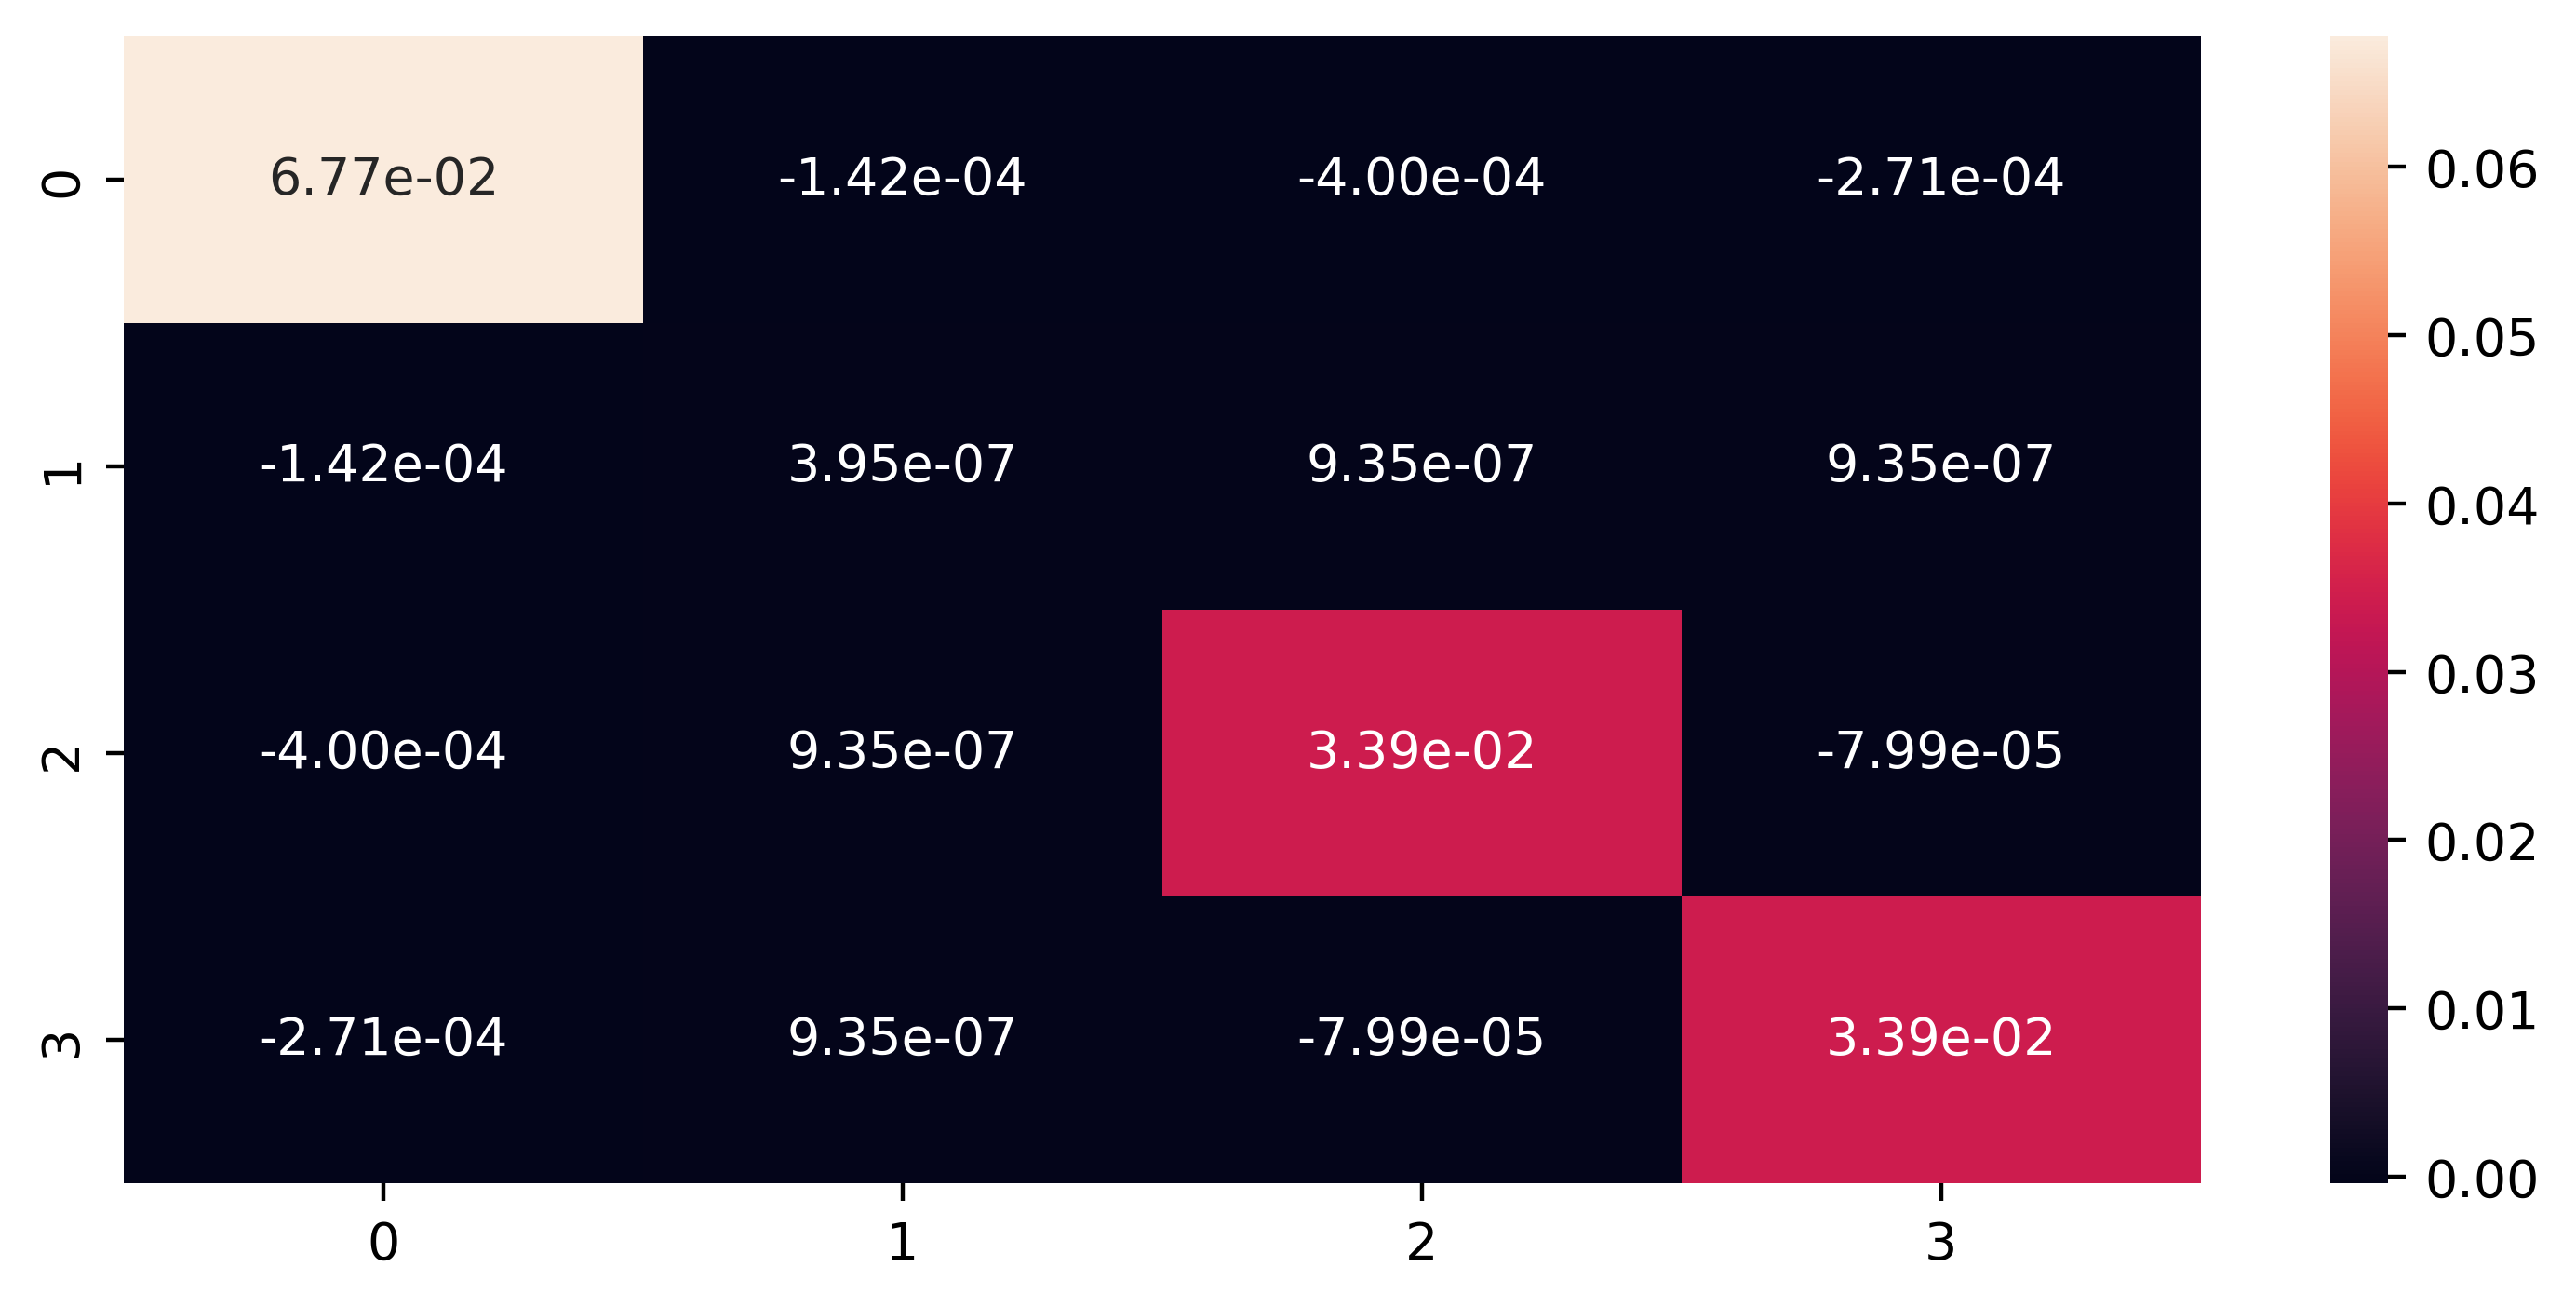

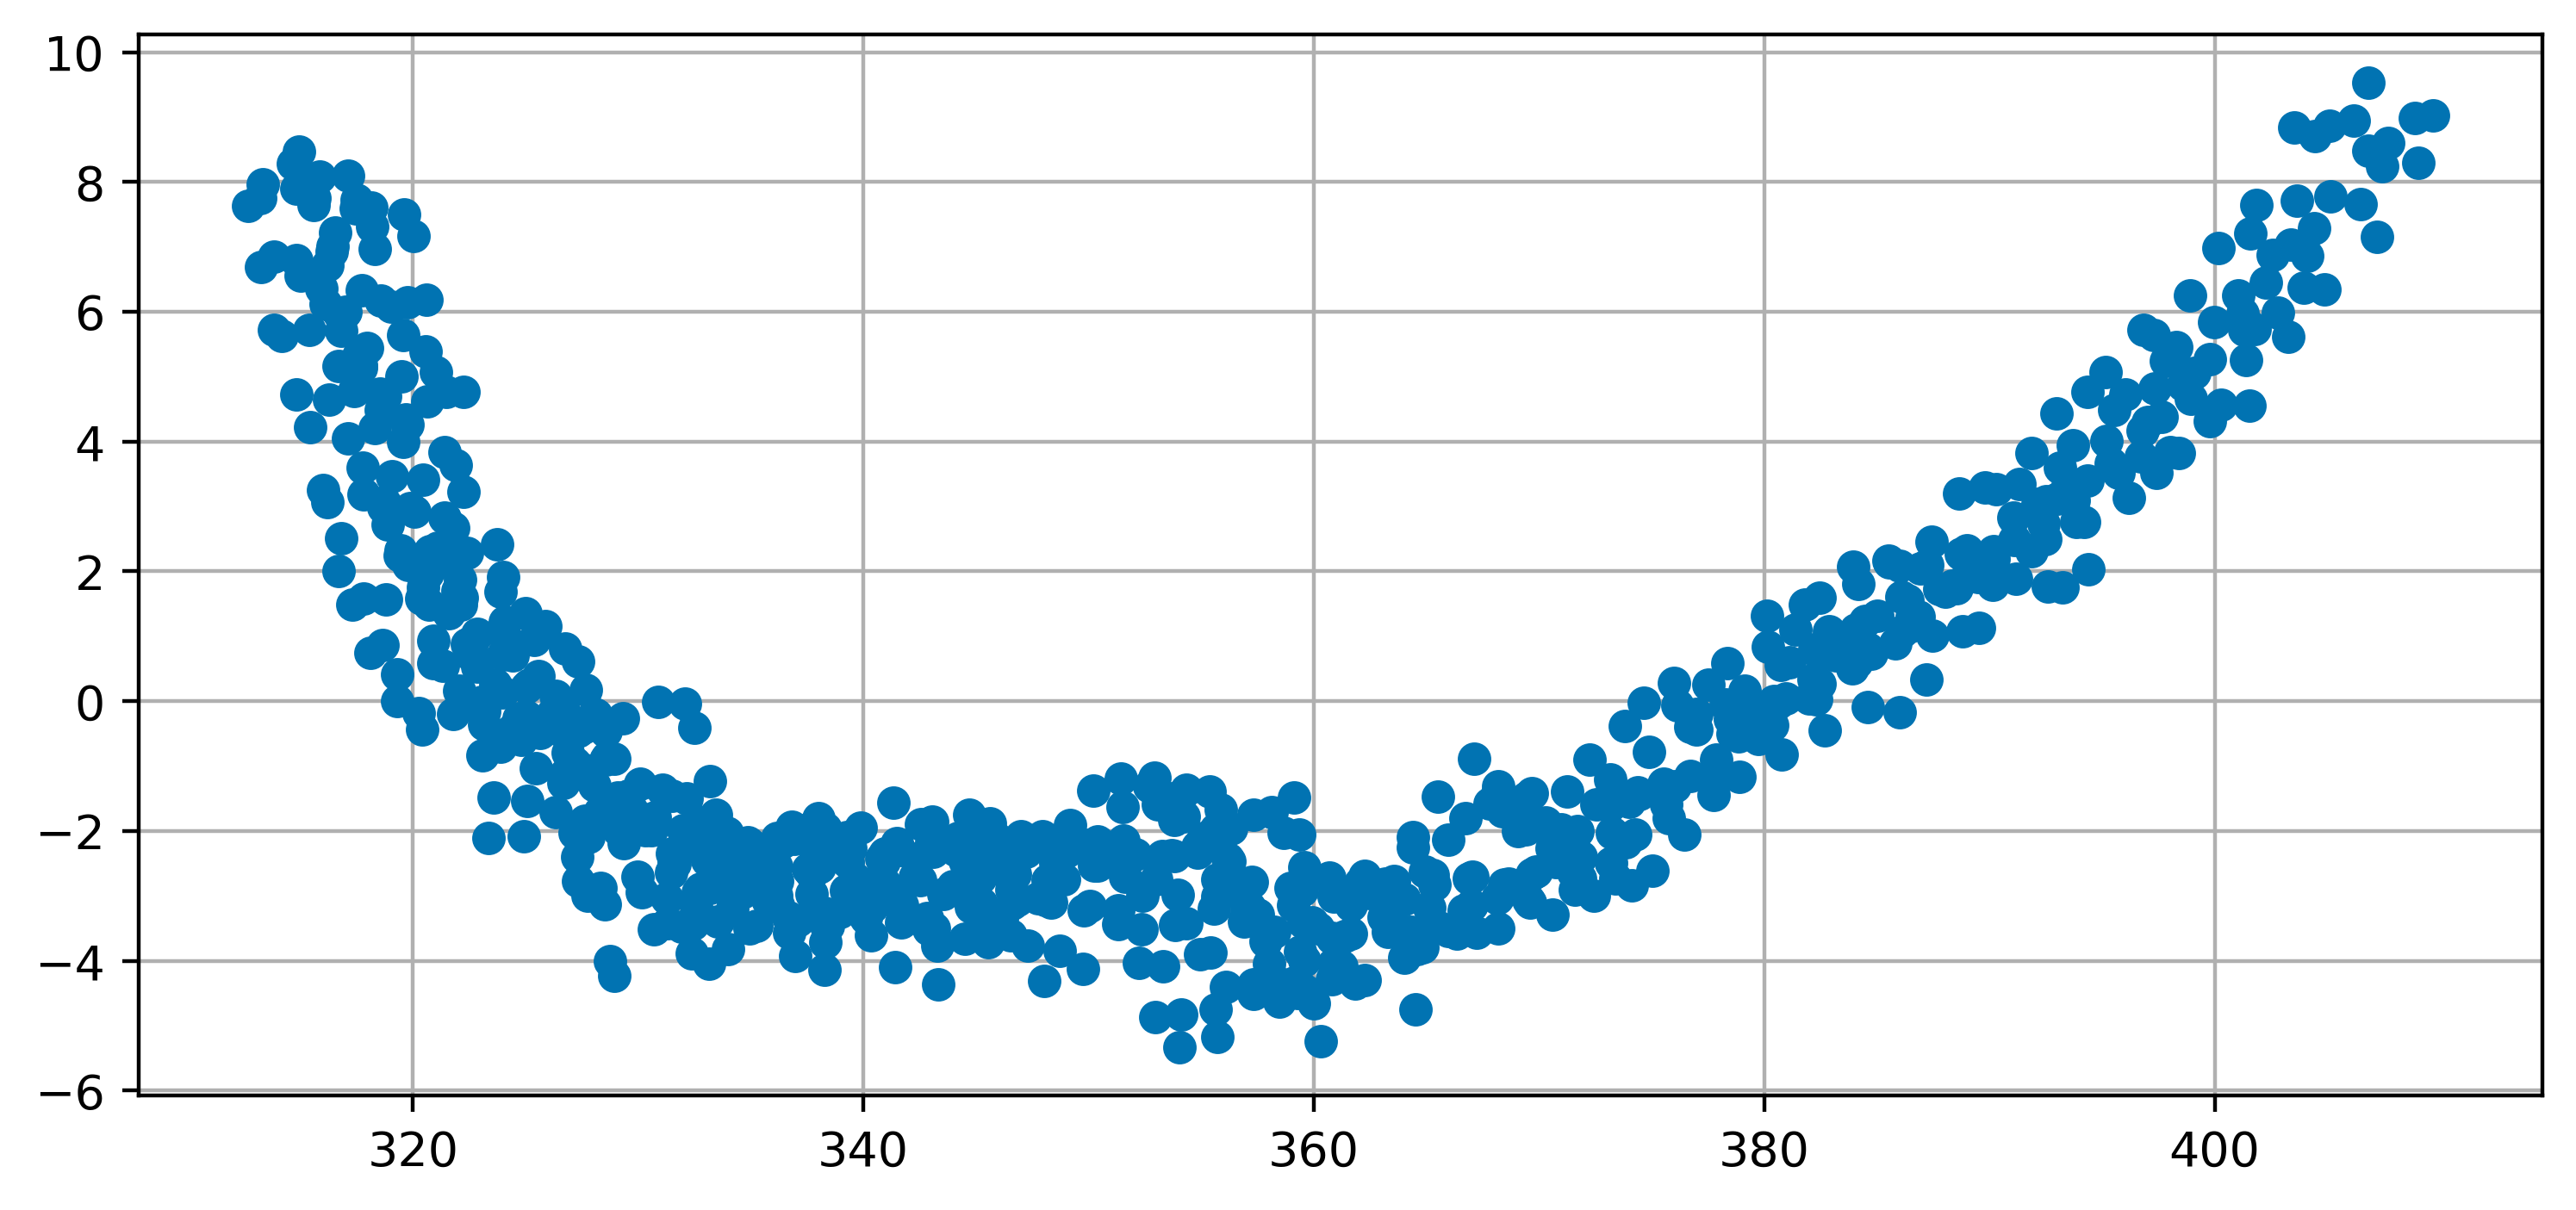

In [4]:
# Estimate parameters for OLS model
ols_param = inv(X_train.T @ X_train) @ X_train.T @ y_train
ols_res = y_train - X_train @ ols_param
ols_var = ols_res.T @ ols_res / (train_n - param_n)
ols_param_var = ols_var * inv(X_train.T @ X_train)

# Print parameters
print("Parameters:\n", ols_param)

# Plot covariance matrix
sns.heatmap(ols_param_var, annot=True, fmt='.2e')
plt.show()

# Plot residuals as a function of y
plt.scatter(y_train, ols_res)
plt.grid()
plt.show()

In [5]:
# Estimate rho parameter for WLS model
wls_rho = 0

wls_sigma_ctr = lambda rho: np.array(
    [[rho**(abs(e - o % train_n)) 
      for e in range(train_n)] 
     for o in range(train_n)]
)


# Do five iterations of the relaxation algorthim
# NOTE: One additional iteration to store final parameters
for i in range(5+1):
    # Create covariance matrix
    wls_sigma = wls_sigma_ctr(wls_rho)
    wls_sigma_inv = inv(wls_sigma)

    # Estimate parameters for WLS model
    wls_param = inv(X_train.T @ wls_sigma_inv @ X_train) @ X_train.T @ wls_sigma_inv @ y_train
    # Get residuals
    wls_res = y_train - X_train @ wls_param

    # Estimate new rho
    wls_rho = np.corrcoef(wls_res[:-1, 0], wls_res[1:, 0])[0, 1]

    print(wls_rho)

0.9820921007263153
0.9822410526176433
0.9822427429486463
0.9822427623072223
0.98224276252896
0.982242762531475


Parameters:
 [[3.07470864e+02]
 [1.29839150e-01]
 [1.66890379e+00]
 [2.29457132e+00]]


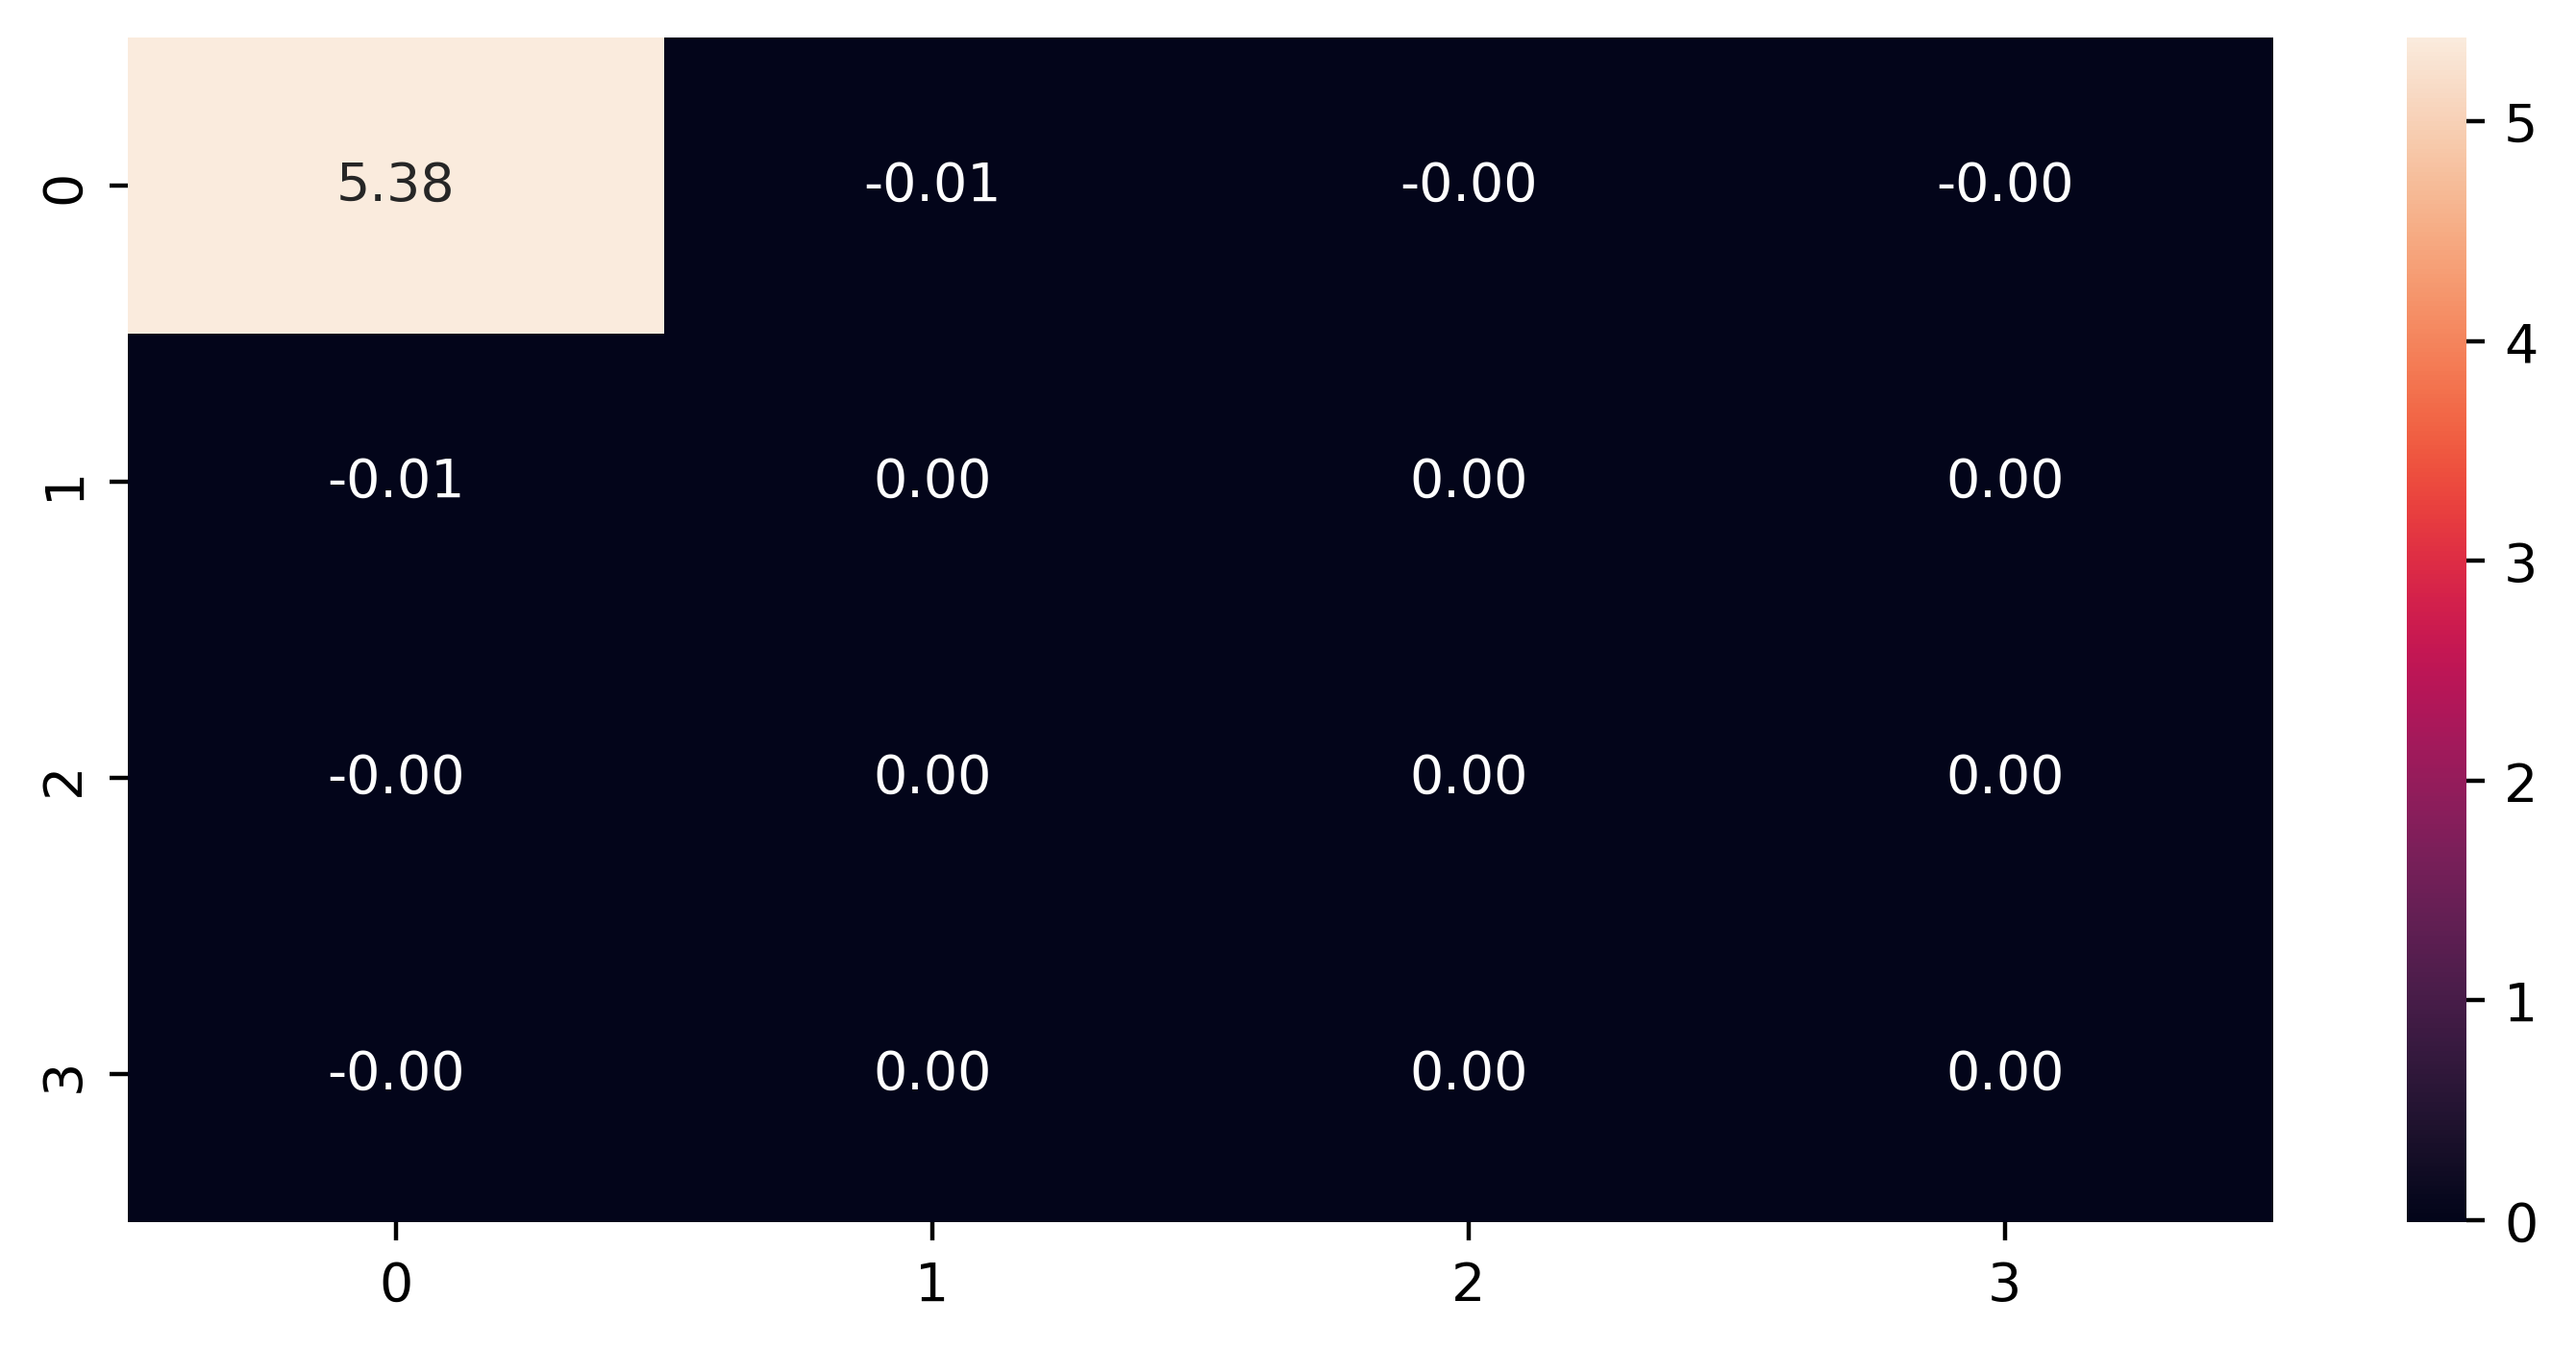

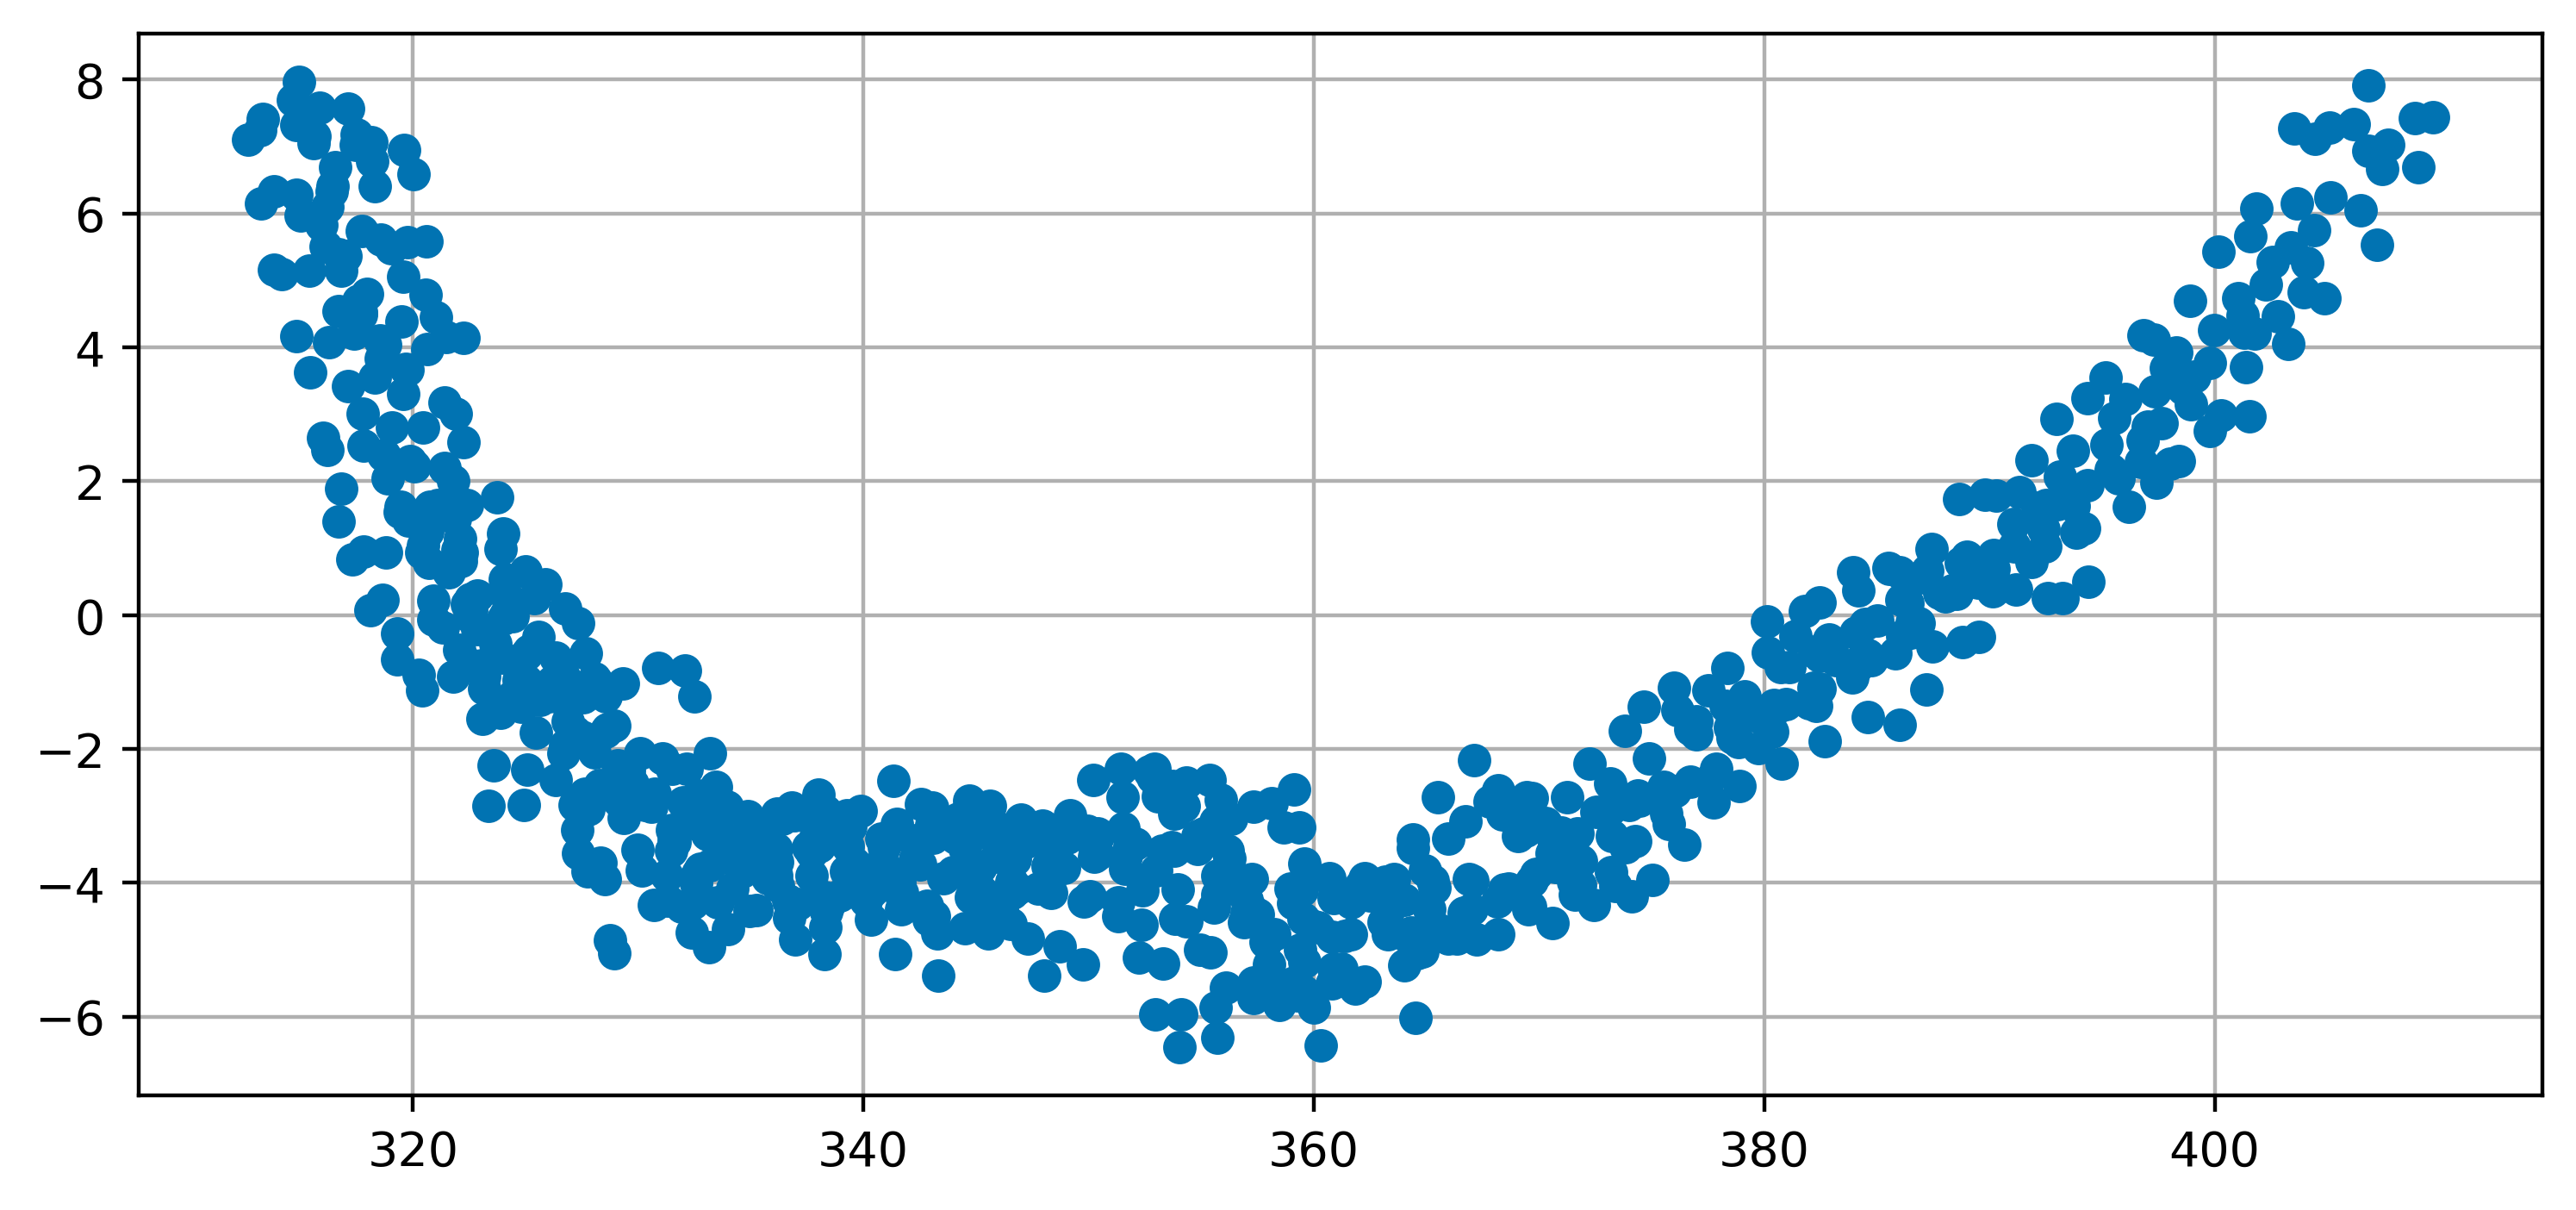

In [6]:
# Estimate variance of residuals
# NOTE: Subtracting one more because also estimating rho
wls_var = wls_res.T @ wls_sigma_inv @ wls_res / (train_n - len(wls_param) - 1)
# Estimate variance of parameters
wls_param_var = wls_var * inv(X_train.T @ wls_sigma_inv @ X_train)


# Print parameters
print("Parameters:\n", wls_param)

# Plot covariance matrix
sns.heatmap(wls_param_var, annot=True, fmt='.2f')
plt.show()

# Plot residuals as a function of y
plt.scatter(y_train, wls_res)
plt.grid()
plt.show()

# 1.3

$$ f(t+1) = L f(t) $$

$$
    f(0) = \begin{bmatrix} 
        1 \\
        0 \\
        sin(\frac{2 \pi}{12} \cdot 0) \\
        cos(\frac{2 \pi}{12} \cdot 0)
    \end{bmatrix}
$$

$$
    f(t) = \begin{bmatrix} 
        1 \\
        t \\
        sin(\frac{2 \pi}{12} t) \\
        cos(\frac{2 \pi}{12} t)
    \end{bmatrix}\\

    L = \begin{bmatrix}
        1 & 0 &                        0 &                       0\\
        1 & 1 &                        0 &                       0\\
        0 & 0 &  cos(\frac{2 \pi}{12}) & sin(\frac{2 \pi}{12})\\
        0 & 0 & -sin(\frac{2 \pi}{12}) & cos(\frac{2 \pi}{12})\\
    \end{bmatrix}\\

    f(t+1) = \begin{bmatrix} 
        1 \\
        t+1 \\
        sin(\frac{2 \pi}{12} (t+1)) \\
        cos(\frac{2 \pi}{12} (t+1))
    \end{bmatrix}
$$

In [7]:
def llt_pred_interval(y_pred, t, F, f, var, alpha = 0.05):
    return y_pred + np.array([1, -1]) * stats.t.ppf(1-alpha/2, t - param_n) * np.sqrt(var) * np.sqrt(1 + f.T @ inv(F) @ f)


def llt_predict(start = 10, lamb = 0.9):
    assert start > 0, "Start must be greater than 0"

    # Create inverse transition matrix
    L_inv = inv(np.array([
        [1, 0, 0, 0],
        [1, 1, 0, 0],
        [0, 0,  np.cos(2 * np.pi / p), np.sin(2 * np.pi / p)],
        [0, 0, -np.sin(2 * np.pi / p), np.cos(2 * np.pi / p)]
    ]))

    # Create design matrix for t'th time step
    f = lambda t: np.array([[1, t, np.sin(2 * np.pi / p * t), np.cos(2 * np.pi / p * t)]]).T
    f_0 = f(0)

    F = np.zeros((param_n, param_n))
    h = np.zeros((param_n, 1))


    # Store predictions and variances
    y_pred_train = []
    y_pred_train_interval = []
    y_pred_train_mean = []
    y_pred_train_var = []
    y_pred_train_var_sum = 0
    thetas = []

    # Go through each data point and make one-step predictions
    for i in range(0, train_n):
        # If burn-in period is over, make predictions
        if i >= start:
            F_inv = inv(F)
            
            # Calculate parameters for previous time step
            theta = F_inv @ h

            # Make one step prediction using parameters 
            #  from previous data to predict current data.
            y_pred = f(1).T @ theta


            # Calculate noise variance from next prediction
            y_pred_train_var_sum += ((y_train[i, 0] - y_pred[0])**2 / (1 + f(1).T @ F_inv @ f(1)))[0, 0]
            y_pred_train_var.append(y_pred_train_var_sum/(i - start + 1))


            # Store predictions
            y_pred_train.append(y_pred[0, 0])
            y_pred_train_mean.append(theta[0, 0])
            thetas.append(theta)


            # Store prediction interval
            y_pred_train_interval.append(llt_pred_interval(y_pred, i-1, F, f(1), y_pred_train_var[-1], 0.05))


        # Update F and h
        F = F + lamb**i * f(-i) @ f(-i).T
        h = lamb * L_inv @ h + f_0 @ y_train[i:i+1]


    # Calculate final parameters
    theta = inv(F) @ h
    thetas.append(theta)

    # Make predictions for test data
    y_pred_test = np.array([f(t+1).squeeze() for t in range(test_n)]) @ theta
    
    # Make intervals for test data
    y_pred_test_interval = np.array([llt_pred_interval(y_pred_test[t], train_n, F, f(t + 1), y_pred_train_var[-1], 0.05) for t in range(test_n)]).squeeze()


    # Return a big mess
    return np.array(y_pred_train), np.array(y_pred_train_interval).squeeze(), np.array(y_pred_train_mean), np.array(y_pred_train_var), y_pred_test, y_pred_test_interval



# Amount of data to skip predictions for
burn_in_1 = 10

# Retrieve predictions
llt_y_pred_train, llt_y_pred_train_interval, llt_y_pred_train_mean, llt_y_pred_train_var, llt_y_pred_test, llt_y_pred_test_interval = llt_predict(start = burn_in_1, lamb = 0.9)

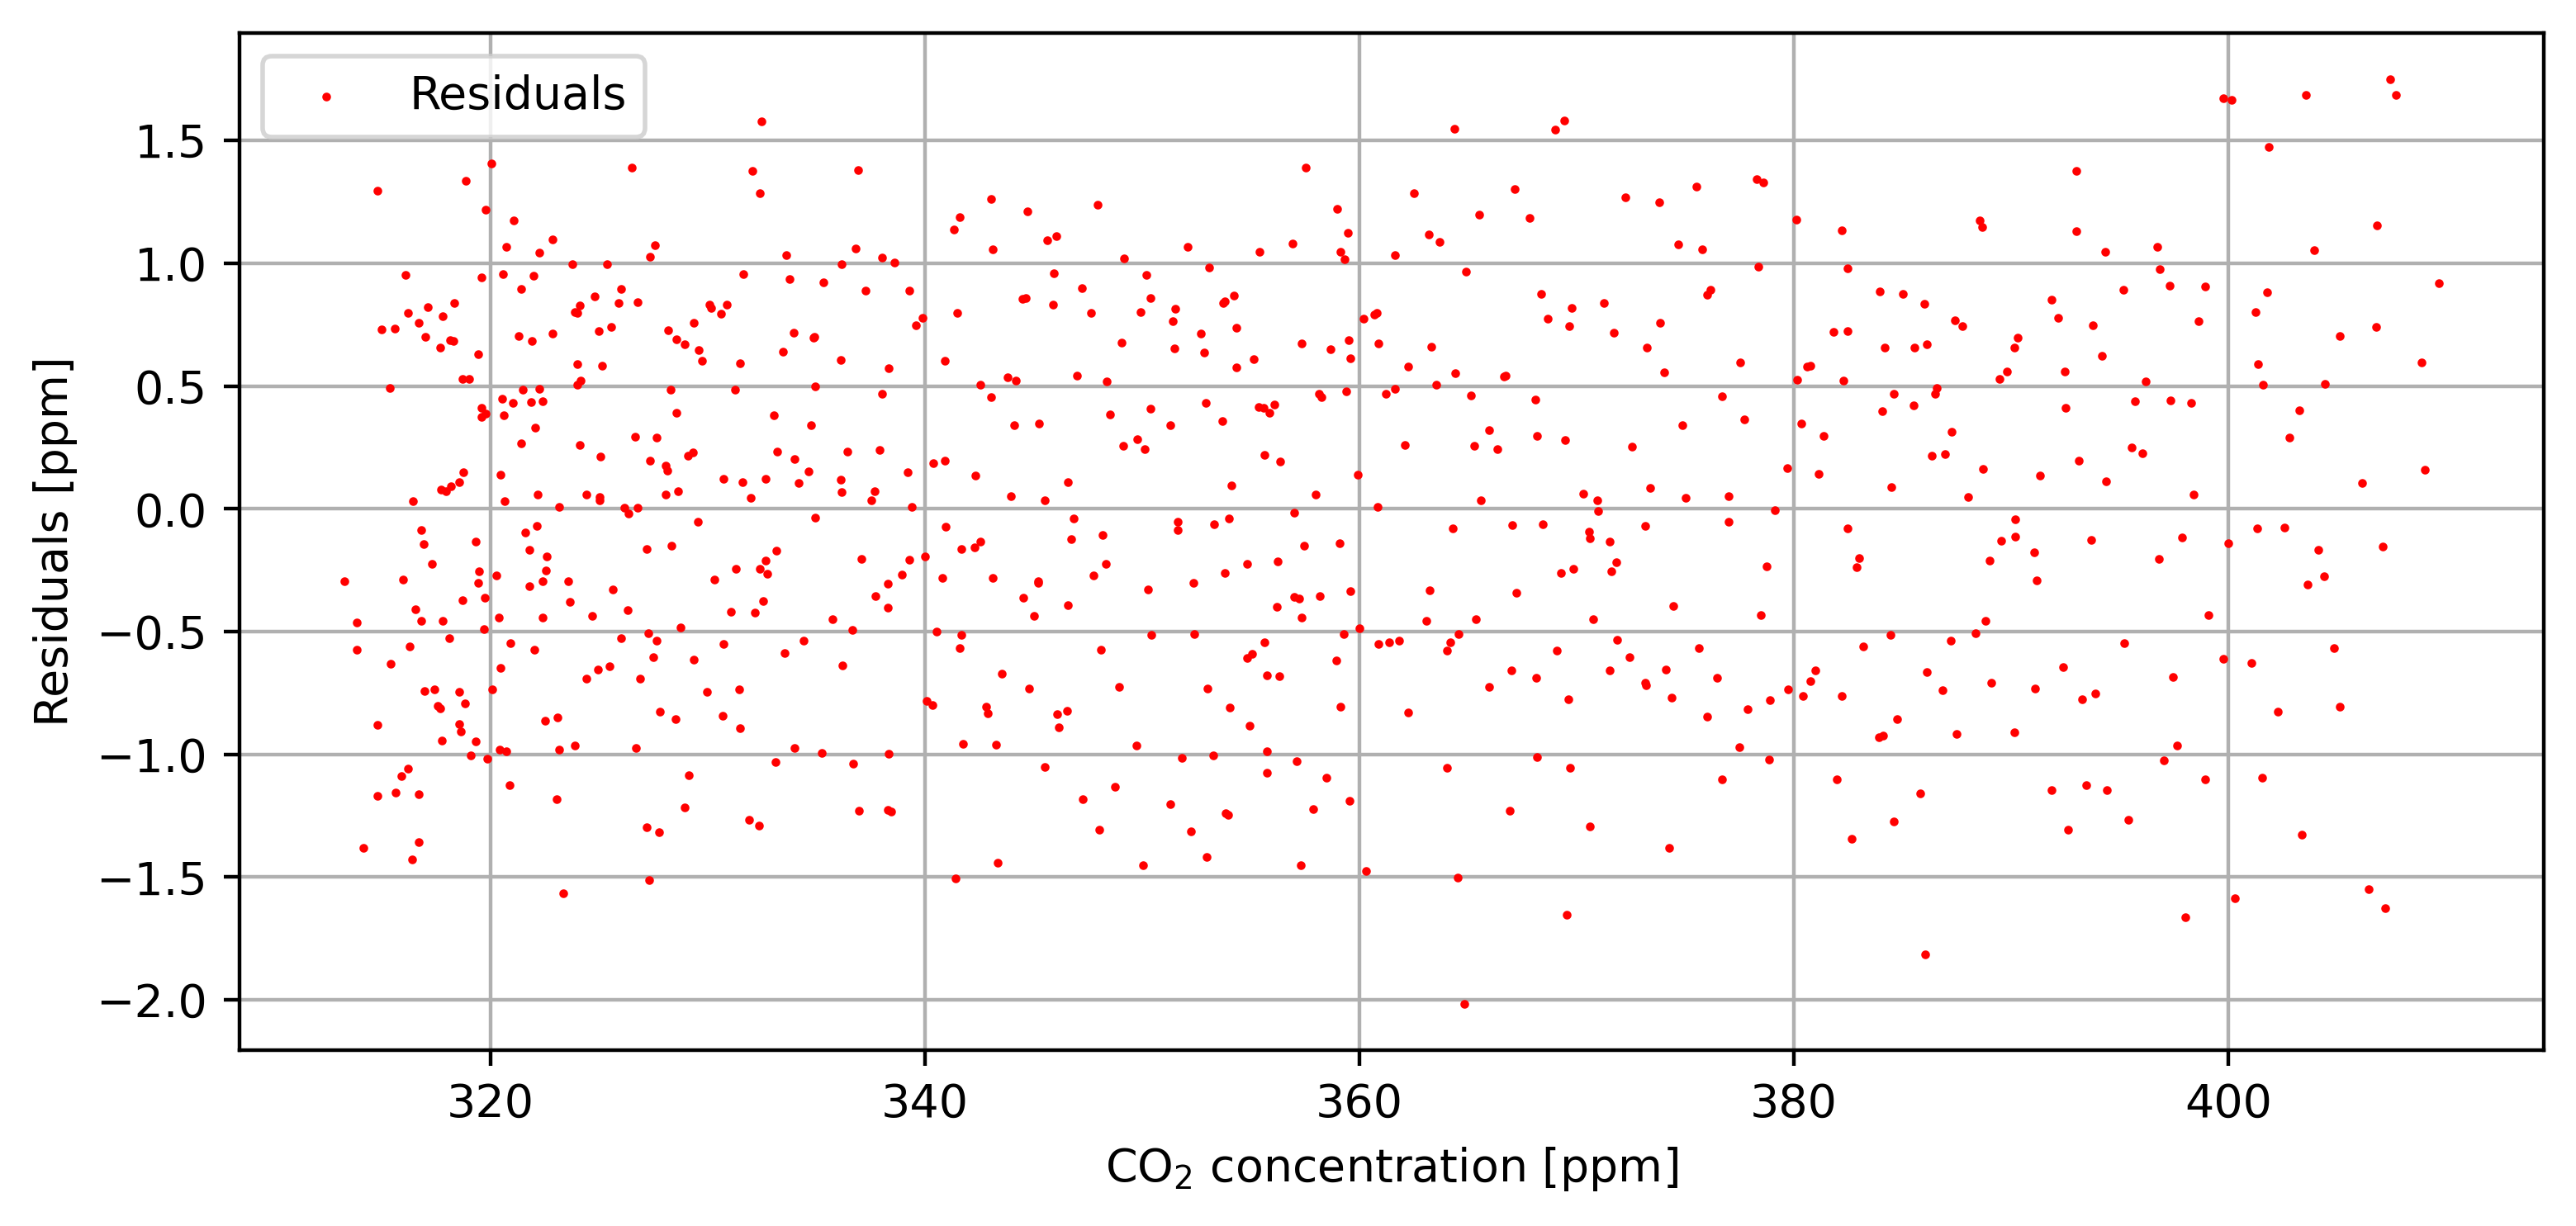

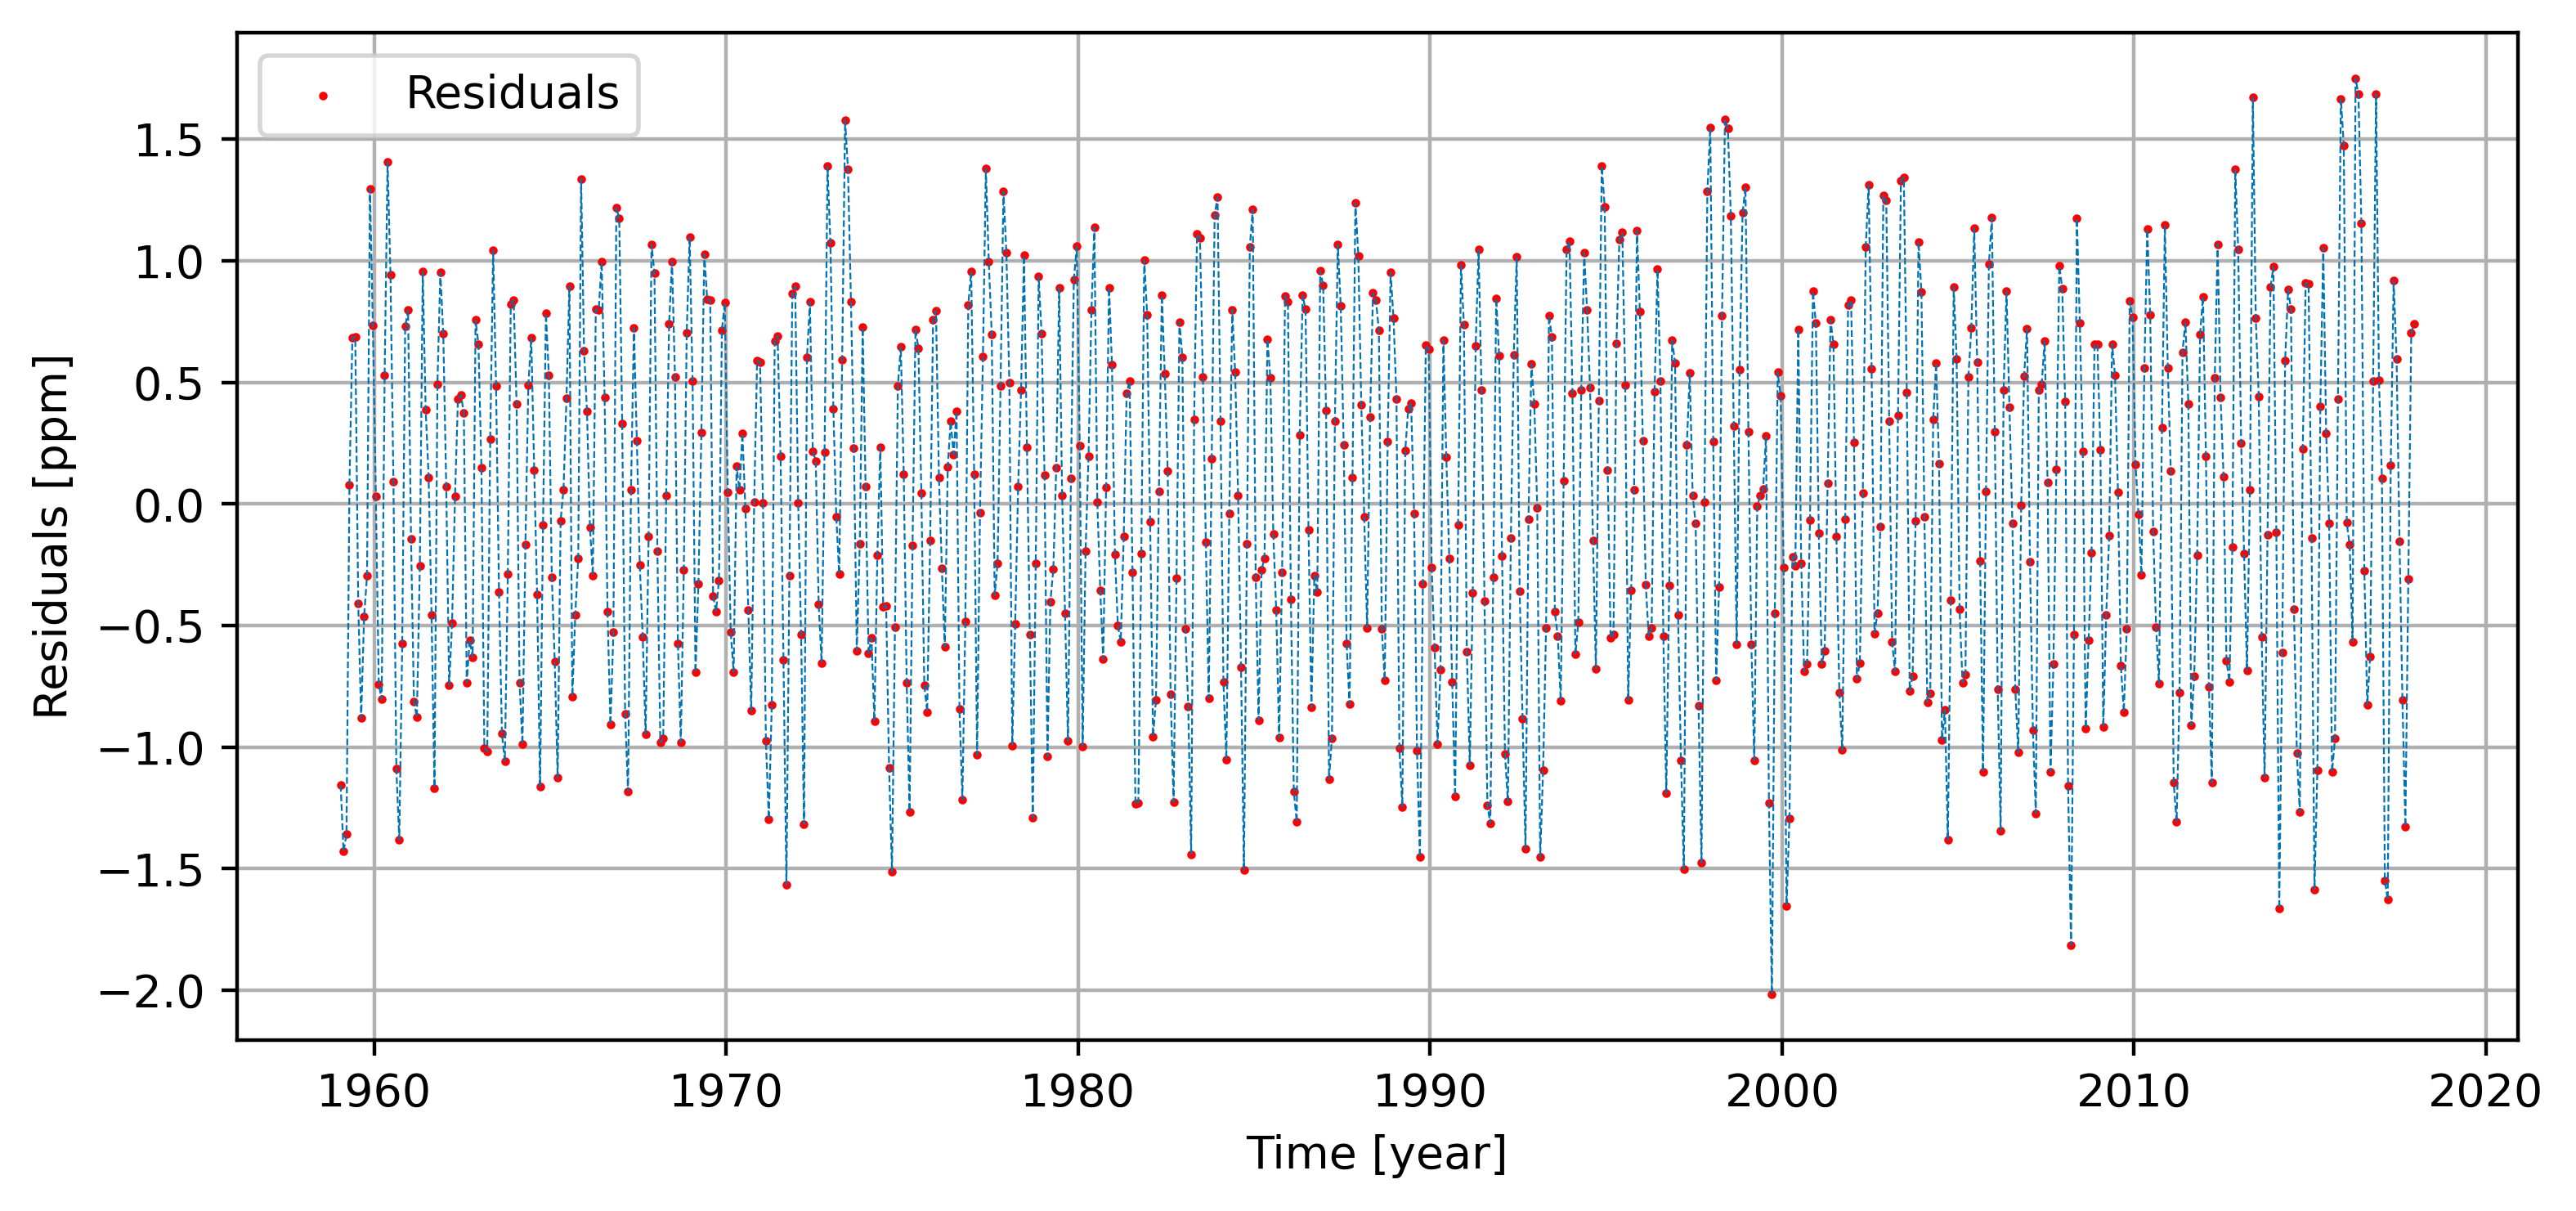

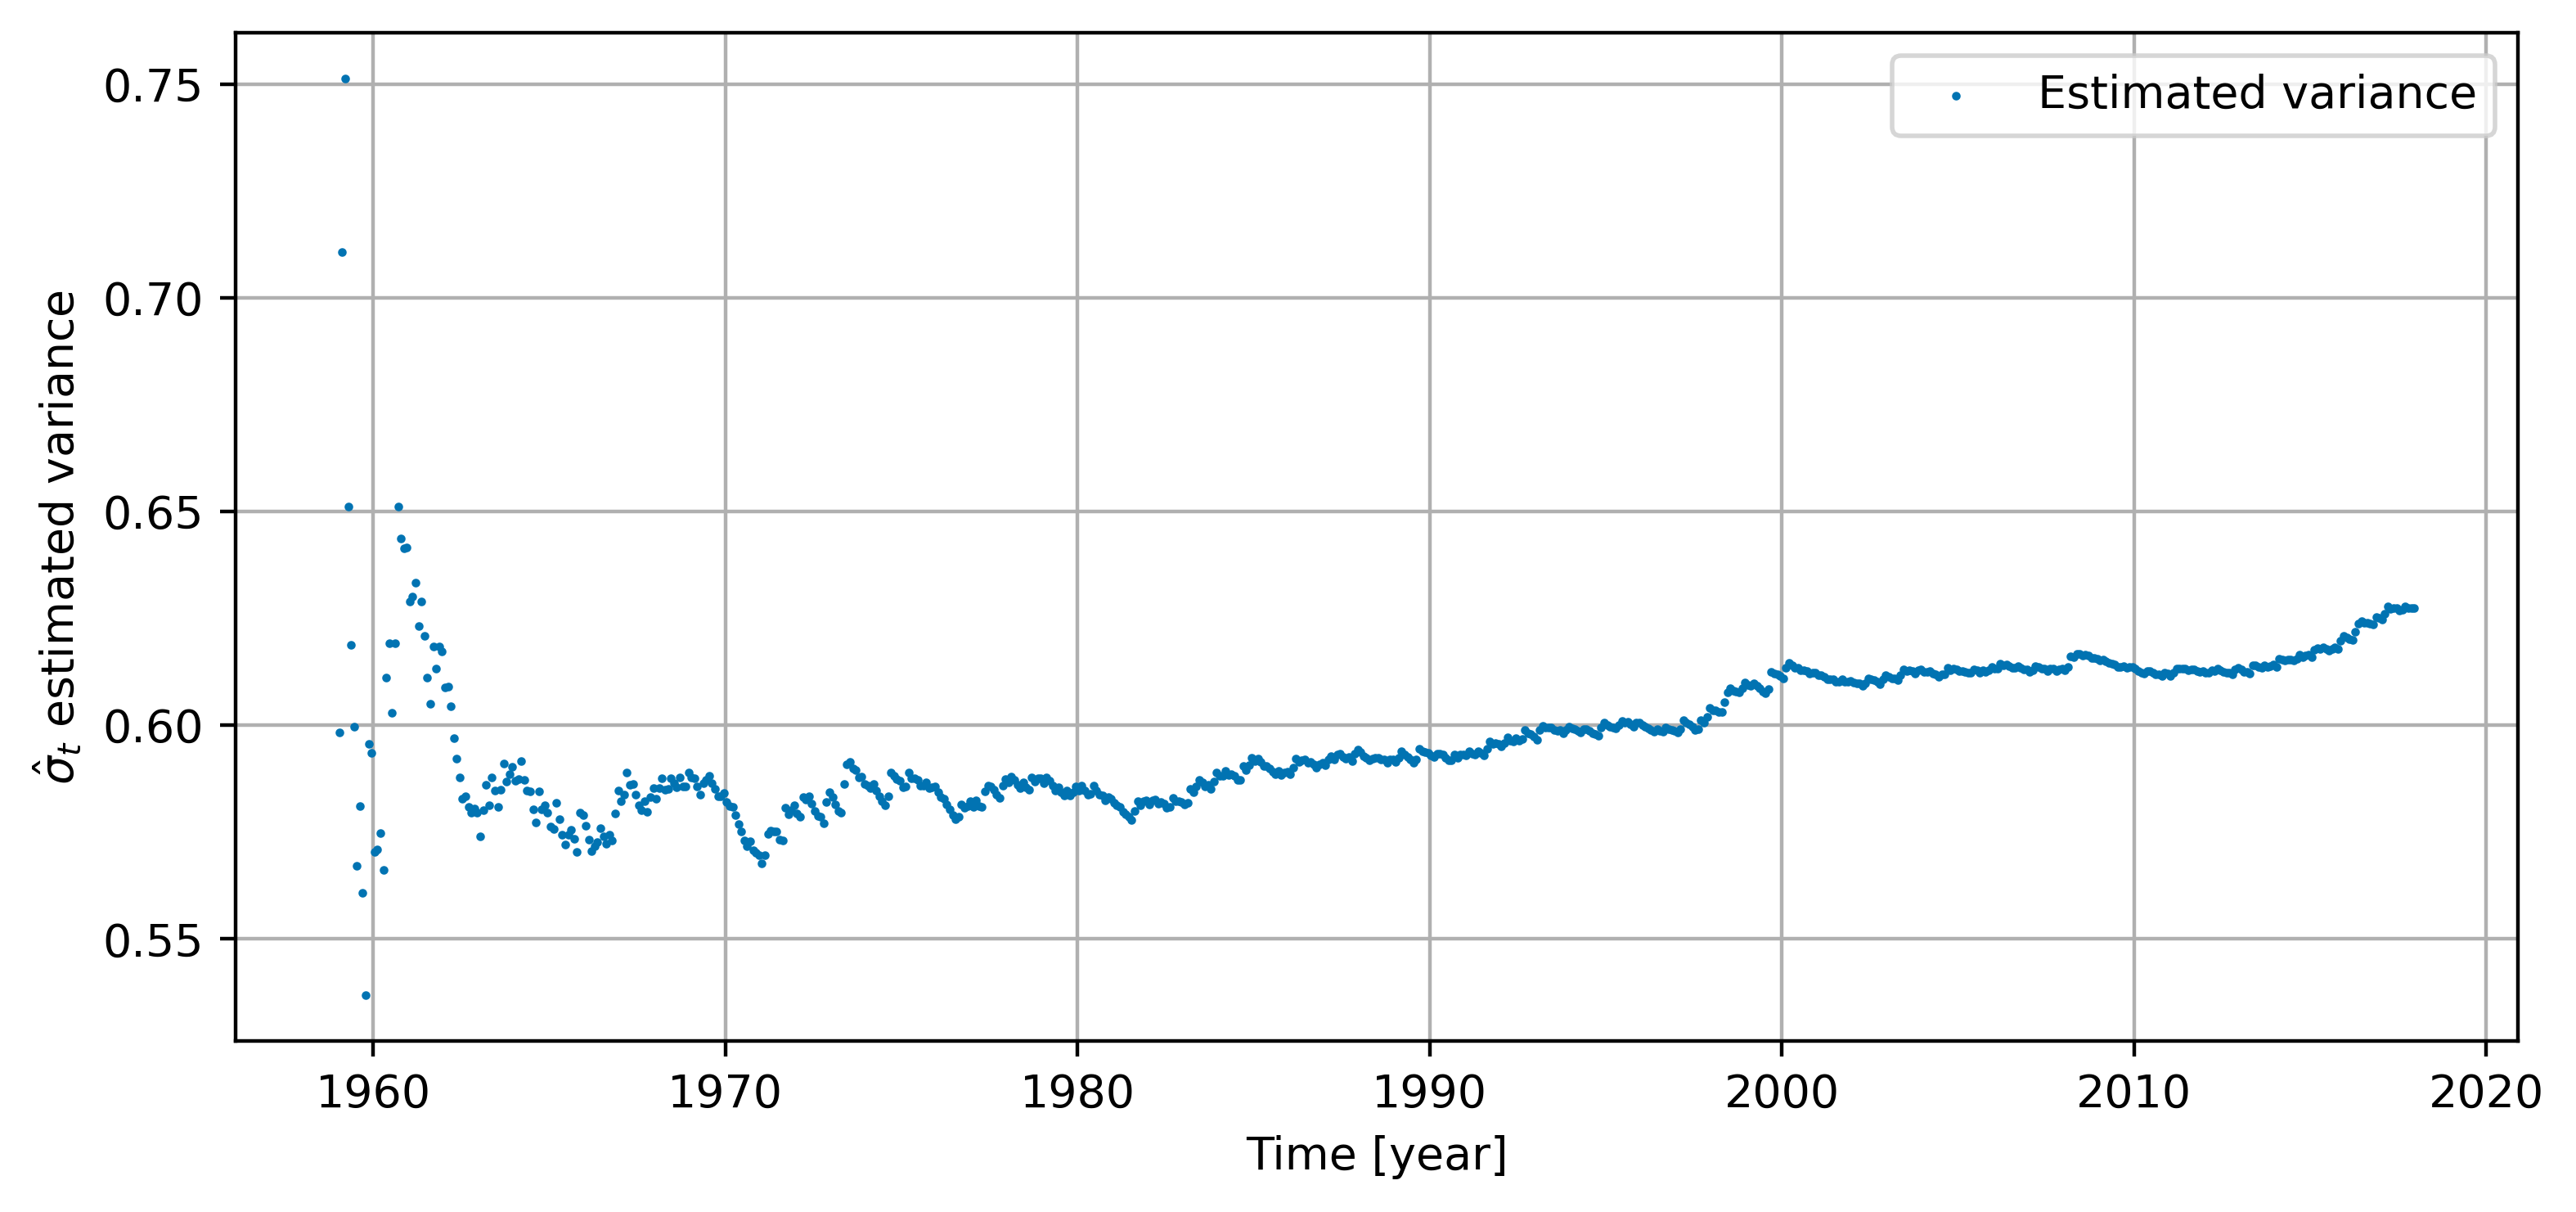

In [8]:
llt_residuals = y_train[burn_in_1:, 0] - llt_y_pred_train

# Plot residuals as function of y
plt.scatter(y_train[burn_in_1:, 0], llt_residuals, s=0.8, c='r', label='Residuals')

plt.xlabel("CO$_2$ concentration [ppm]")
plt.ylabel("Residuals [ppm]")

plt.legend()
plt.grid()

plt.show()


# Plot residuals as function of time
plt.plot(time_train[burn_in_1:], llt_residuals, '--', linewidth=0.4)
plt.scatter(time_train[burn_in_1:], llt_residuals, c='r', s=0.8, label='Residuals')

plt.xlabel("Time [year]")
plt.ylabel("Residuals [ppm]")

plt.legend()
plt.grid()

plt.show()


# Plot variance
plt.scatter(time_train[burn_in_1:], np.sqrt(llt_y_pred_train_var), s=0.8, label='Estimated variance')

plt.xlabel("Time [year]")
plt.ylabel("$\hat \sigma_t$ estimated variance")

plt.legend()
plt.grid()

plt.show()

# 1.4


100%|██████████| 1000/1000 [01:25<00:00, 11.76it/s]


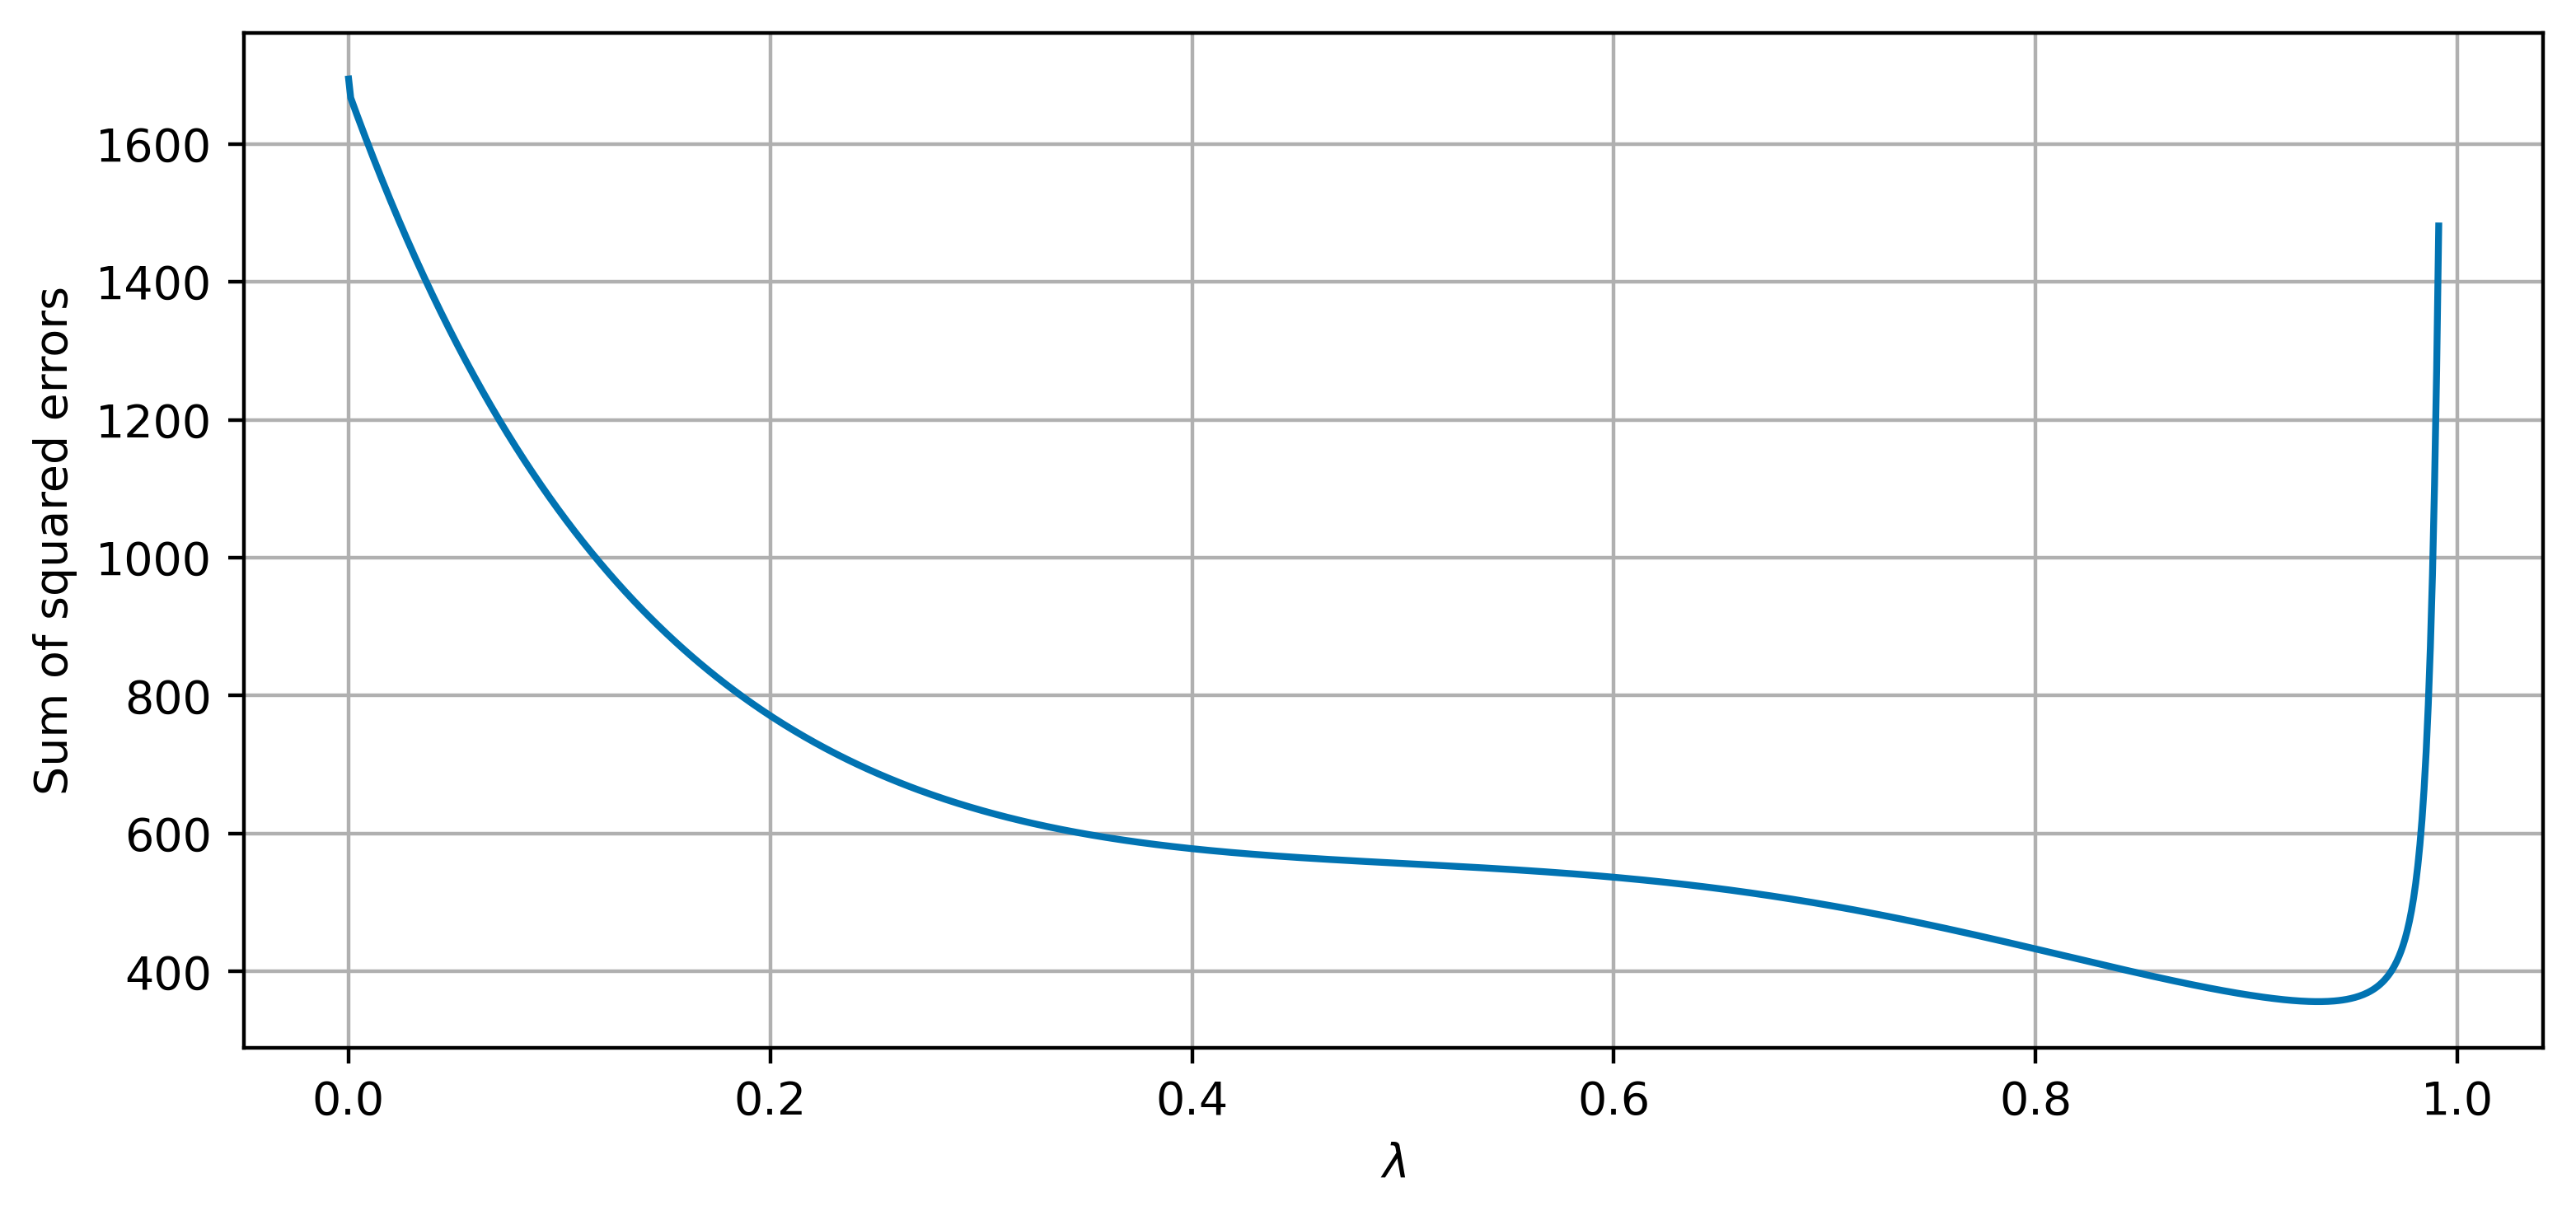

0.933476076076076


In [9]:
# Set ranges of points to skip and lambdas to test
burn_in_2 = 100
lambs = np.linspace(0+2e-4, 1-9e-3, 1000)

# Predict and calculate squared error for each lambda
sqerrors = [((y_train[burn_in_2:, 0] - llt_predict(start=burn_in_2, lamb=l)[0])**2).sum() for l in tqdm(lambs)]

# Plot squared error as a function of lambda
plt.plot(lambs, sqerrors)

plt.grid()
plt.xlabel('$\lambda$')
plt.ylabel('Sum of squared errors')

plt.show()

print(lambs[800+np.argmin(sqerrors[800:])])

# 1.1

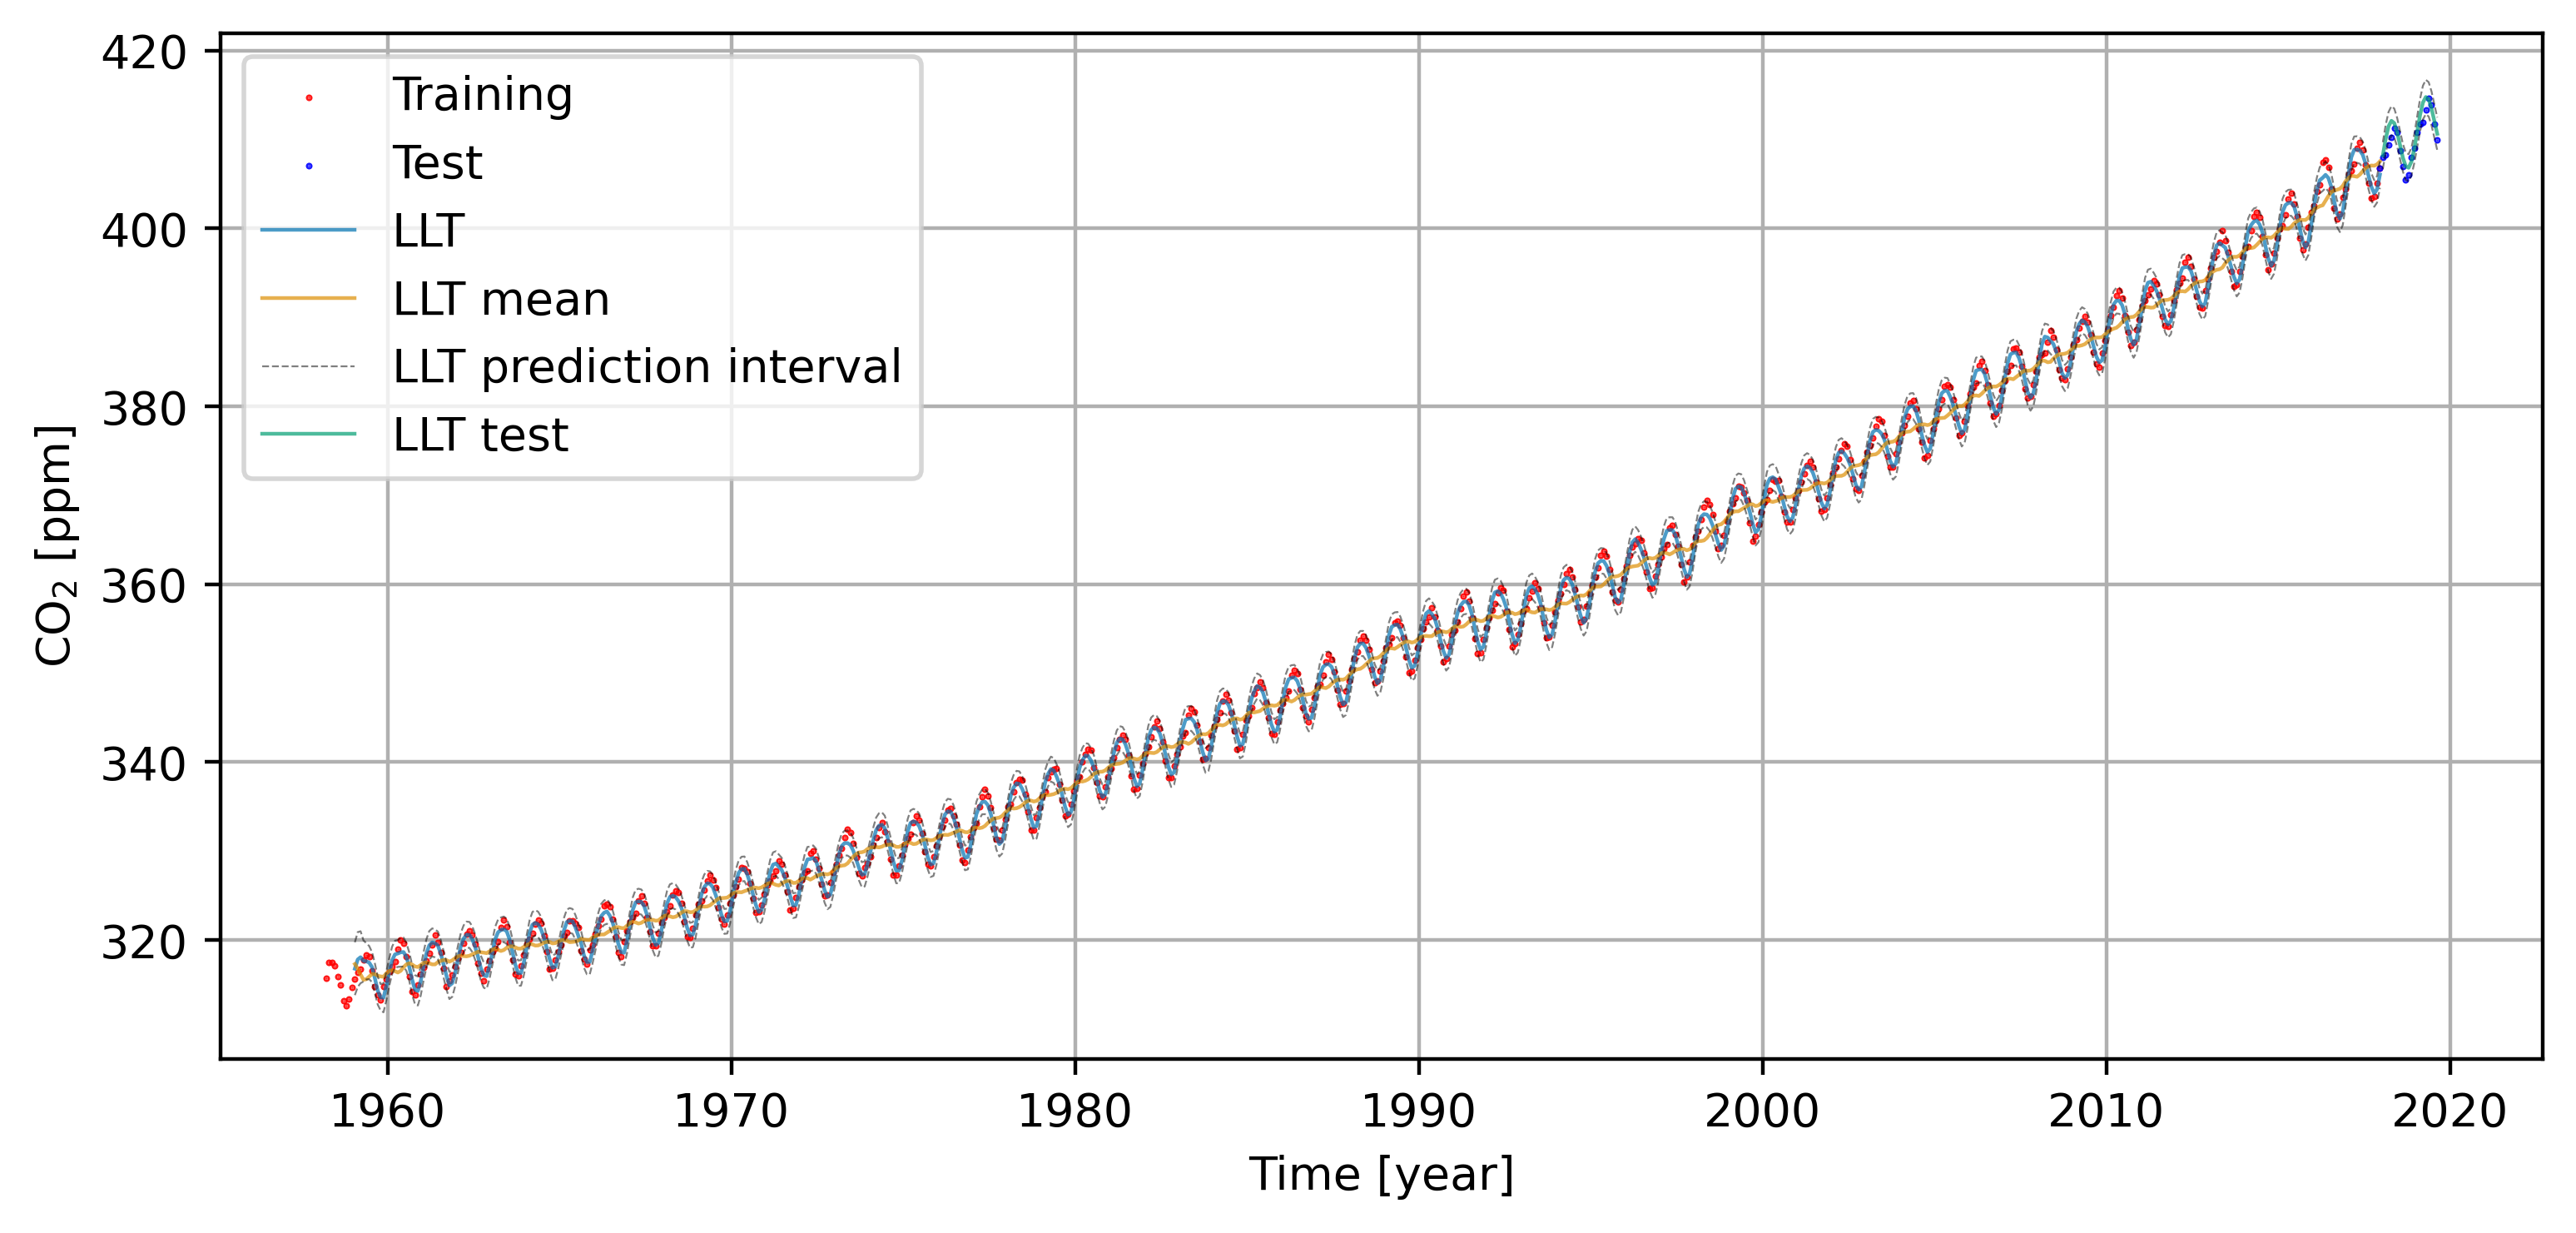

In [10]:
# Set plot options
plot_model_params = {"alpha": 0.7, "linestyle": '-', "linewidth": 0.8}
plot_interval_params = {"alpha": 0.5, "linestyle": '--', "linewidth": 0.4}
plot_data_params = {"alpha": 0.9, "s": 0.2}


# Plot data
plt.scatter(time_train, co2_train, label="Training", c="r", **plot_data_params)
plt.scatter(np.concatenate([time_train[-1, None], time_test]), np.concatenate([co2_train[-1, None], co2_test]), label="Test", c='b', **plot_data_params)

# Plot model predictions
plt.plot(time_train[burn_in_1:], llt_y_pred_train, label="LLT", **plot_model_params)
plt.plot(time_train[burn_in_1:], llt_y_pred_train_mean, label="LLT mean", **plot_model_params)
plt.plot(time_train[burn_in_1:], llt_y_pred_train_interval[:, 0], label="LLT prediction interval", c='k', **plot_interval_params)
plt.plot(time_train[burn_in_1:], llt_y_pred_train_interval[:, 1], c='k', **plot_interval_params)

plt.plot(time_test, llt_y_pred_test, label="LLT test", **plot_model_params)
plt.plot(time_test, llt_y_pred_test_interval[:, 0], c='k', **plot_interval_params)
plt.plot(time_test, llt_y_pred_test_interval[:, 1], c='k', **plot_interval_params)
# plt.plot(time_train, X_train @ ols_param, label="OLS", **plot_model_params)
# plt.plot(time_train, X_train @ wls_param, label="WLS", **plot_model_params)


# Plot
plt.xlabel("Time [year]")
plt.ylabel("CO$_2$ [ppm]")

plt.legend()
plt.grid()

plt.show()


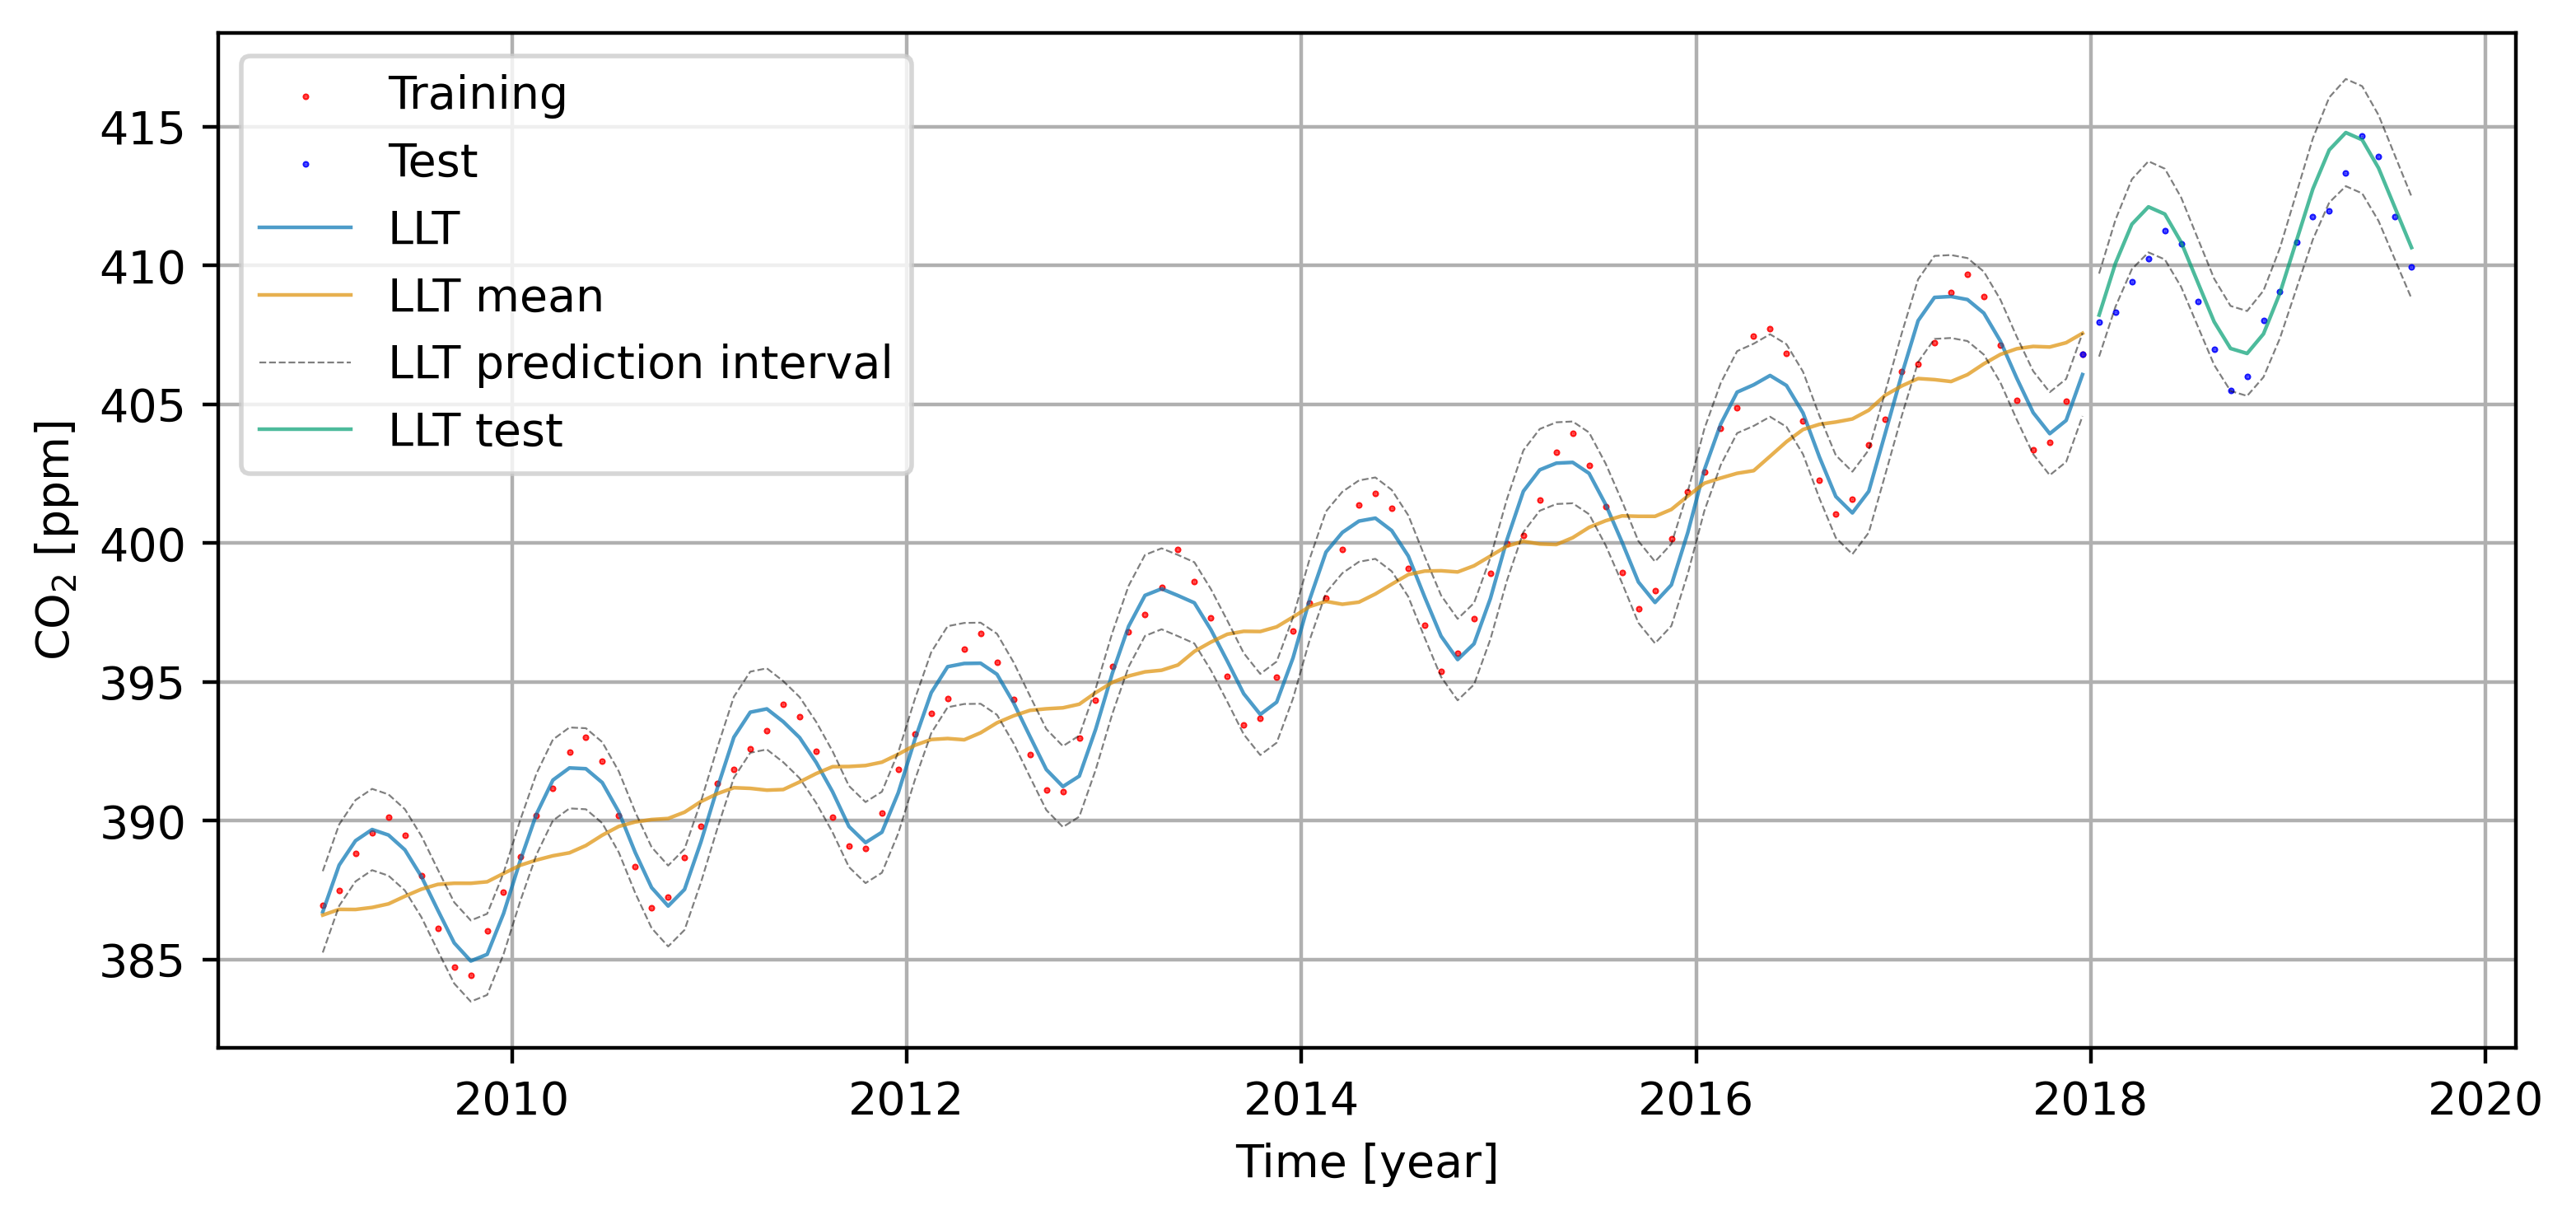

In [11]:
zoom_idx = np.argwhere(year[~test_idx] >= 2009).squeeze()

# Plot data
plt.scatter(time_train[zoom_idx], co2_train[zoom_idx], label="Training", c="r", **plot_data_params)
plt.scatter(np.concatenate([time_train[-1, None], time_test]), np.concatenate([co2_train[-1, None], co2_test]), label="Test", c='b', **plot_data_params)

# Plot model predictions
plt.plot(time_train[zoom_idx], llt_y_pred_train[zoom_idx-burn_in_1], label="LLT", **plot_model_params)
plt.plot(time_train[zoom_idx], llt_y_pred_train_mean[zoom_idx-burn_in_1], label="LLT mean", **plot_model_params)
plt.plot(time_train[zoom_idx], llt_y_pred_train_interval[zoom_idx-burn_in_1, 0], label="LLT prediction interval", c='k', **plot_interval_params)
plt.plot(time_train[zoom_idx], llt_y_pred_train_interval[zoom_idx-burn_in_1, 1], c='k', **plot_interval_params)

plt.plot(time_test, llt_y_pred_test, label="LLT test", **plot_model_params)
plt.plot(time_test, llt_y_pred_test_interval[:, 0], c='k', **plot_interval_params)
plt.plot(time_test, llt_y_pred_test_interval[:, 1], c='k', **plot_interval_params)


# Plot
plt.xlabel("Time [year]")
plt.ylabel("CO$_2$ [ppm]")

plt.legend()
plt.grid()

plt.show()

In [12]:
# Print table of future predictions
y_pred_test_idx = np.array([1, 2, 6, 12, 20])-1

for t, true, pred, lower, upper in zip(y_pred_test_idx+1, co2_test[y_pred_test_idx], llt_y_pred_test[y_pred_test_idx, 0], llt_y_pred_test_interval[y_pred_test_idx, 1], llt_y_pred_test_interval[y_pred_test_idx, 0]):
    print(f"{t} & {true:.2f} &{pred:.2f} & {lower:.2f} & {upper:.2f}\\\\")

1 & 407.96 &408.21 & 406.72 & 409.71\\
2 & 408.32 &410.08 & 408.51 & 411.64\\
6 & 410.79 &410.83 & 409.22 & 412.44\\
12 & 409.07 &409.00 & 407.37 & 410.62\\
20 & 409.95 &410.64 & 408.81 & 412.48\\
